# Efficiently sampling mixture models - a pedagogical exploration and comparison of methods

_Boris Leistedt, May 2017_

_with valuable comments from Semyeong Oh, Jo Bovy._

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Efficiently%20sampling%20mixture%20models%20-%20a%20pedagogical%20exploration%20and%20comparison%20of%20methods.ipynb). 

We will consider the problem of efficiently inferring the parameters of mixture models. We will touch upon the following topics:
- density modelling with Gaussian mixtures
- a first (but incorrect) go at parameter inference with an ensemble sampler (emcee)
- degeneracies, re-parametrization, and correct parameter sampling with emcee
- mapping the full multimodal solution with nested sampling (PolyChord)
- efficient (but unimodal) sampling with Hamiltonian Monte Carlo (HMC) 
- gradients and hessians with automatic differentiation
- jointly sampling all the latent variables with autodifferientiated HMC

Full disclaimer: this tutorial is by no means the final word on how to sample mixture models!

### Requirements

Some basic knowledge of Bayes theorem, parameter inference via MCMC, and hierarchical probabilistic models.

If you want to run this notebook, you will need `matplotlib`, `scipy`, `numpy`, `autograd`, `emcee`, and `Polychord`.

### Some useful references 

- Introduction to finite mixture models: https://arxiv.org/abs/1705.01505
- Extreme deconvolution, an alternative to sampling mixture models: https://arxiv.org/abs/0905.2979
- M. Betancourt's simplex-hypercube mapping: https://arxiv.org/abs/1010.3436
- Introduction to HMC: https://arxiv.org/abs/1206.1901
- Continuously tempered HMC method: https://arxiv.org/abs/1704.03338
- The Matrix Cookbook: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=3274 
- emcee sampler: http://dan.iel.fm/emcee/current
- Polychord paper: https://arxiv.org/abs/1506.00171

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler
import itertools

import emcee
import corner

import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from autograd import grad, hessian
import numpy as onp
from scipy.optimize import minimize
from scipy.misc import derivative

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

## What are mixture models?

In the realm of probabilistic models, mixture models are very common. They refer to describing a probability distribution as a linear sum of components

$p(x) = \sum_i \alpha_i K_i(x)$

The kernels $\{ K_i(x) \}$ usually belong to some family of probability distributions (e.g., Gaussians). One is usually interested in inferring the amplitude coefficients as well as the parameters of the kernels (e.g., their positions and sizes). Note that to obtain a valid probability distribution function (PDF), both the kernels and the amplitudes must be normalized, e.g., sum to one:

$\int  K_i(x)\mathrm{d}x = 1 \quad \sum_i \alpha_i = 1$

The kernels do not have to be identical or even belong to the same family. Also note that the mixture could be infinite. Both of those extensions are the state of the art of modern statistical modeling, but are advanced topics which will not be covered here.

You might have already realized that this loose definition gives a lot of flexibility, which may create numerous technical issues, notably in how mixture models are optimized or sampled when fitting data. In particular, there is the infamous "label degeneracy", which refers to the ability to swap components/kernels and leave the total PDF invariant. This is problematic if one attempts to naively sample those parameters with MCMC. Luckily, there are standard tricks to get around this issue, as we will illustrate below. 

Another common issue is the presence of components with low amplidues, infinitely low or high widths. Those are difficult to fit and create various new degeneracies in the posterior distribution. For instance, one can probably add many of those components without changing the quality of the fit to a data set. This is related to model selection for choosing the number of mixtures. We will briefly discuss this issue below.

One of the main restrictions of this notebook is to focus on one-dimensional mixtures. However, if $x$ were multidimensional, most of the discussion below would be unchanged - but many of the calculations and illustrations would be much more difficult. 

## Density modeling with Gaussian Mixtures

We will consider a set of $N$ points $\{x_i ; i=1,\cdots,N\}$ generated from the mixture of $B$ Gaussians, with amplitudes, means, and standard deviations denoted by $\vec{\alpha},\vec{\beta}, \vec{\gamma}$. Thus, each $x_i$ is drawn from

$p(x_i|\vec{\alpha},\vec{\beta}, \vec{\gamma}) = \sum_{b=1}^B \alpha_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)$

We use the notation $\mathcal{N}(x\vert\mu,\sigma^2) = (\sqrt{2\pi}\sigma)^{-1} \exp\left(-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right)$

For each $x_i$, we observe a noisy version $y_i$, with Gaussian noise of standard deviation $\sigma_i$, such that

$p(y_i|x_i, \sigma_i) = \mathcal{N}(y_i|x_i,\sigma^2_i)$

The variables $\alpha_b$ are such that $0 \leq \alpha_b \leq 1$ and $\sum_{b=1}^B \alpha_b = 1$, i.e., they live on the $B$-dimensional simplex.

Let us start by making a simulated data set.

In [40]:
# Those two functions establish a mapping between the B-dimensional simplex 
# and the (B-1)-dimensional unit hypercube. This will be described later on.

def zs_to_alphas(zs):  
    fac = np.concatenate((1 - zs, np.array([1])))
    zsb = np.concatenate((np.array([1]), zs))
    fs = np.cumprod(zsb) * fac
    return fs

def alphas_to_zs(alphas):
    def fun(z):
        return np.sum((zs_to_alphas(z) - alphas)**2.)
    res = minimize(fun, x0=np.repeat(0.5, alphas.size-1))
    return res.x

nobj = 300 
zs = np.array([0.3])
nt = zs.size + 1 # the number of mixtures, i.e. B in the text
alphas = zs_to_alphas(zs)
betas = np.array([0.4, 0.6])
betas.sort()  # sorts them
gammas = np.array([0.05, 0.05])  # fixed to some small values
typecounts = np.random.multinomial(nobj, alphas)
types = np.concatenate([np.repeat(i, ni) for i, ni in enumerate(typecounts)]).astype(int)
xis = betas[types] + gammas[types] * np.random.randn(nobj) # Gaussian draws 
xis = np.array([betas[t] + gammas[t] * np.random.randn() for t in types]) # Gaussian draws 
sigmais = np.random.uniform(0.01, 0.15, size=nobj) 
yis = xis + sigmais * np.random.randn(nobj)  # Gaussian draws from N(x_i, sigma_i)
x_grid = np.linspace(0, 1, 100)
p_x_grid = alphas[None, :] * np.exp(-0.5*((x_grid[:, None] - betas[None, :])/gammas[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas[None, :]

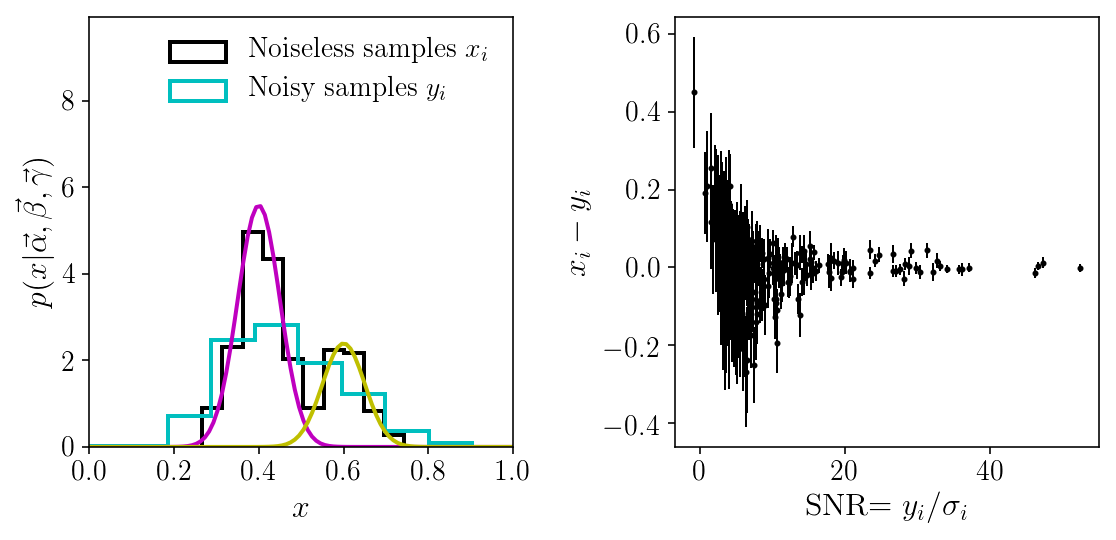

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(xis, histtype='step', normed=True,
           label=r'Noiseless samples $x_i$')
axs[0].hist(yis, histtype='step', normed=True,
           label=r'Noisy samples $y_i$')
for t in range(nt):
    axs[0].plot(x_grid, p_x_grid[:, t])
axs[0].legend(frameon=True).get_frame().set_linewidth(0)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(x|\vec{\alpha}, \vec{\beta}, \vec{\gamma})$')
axs[0].set_xlabel(r'$x$')
axs[1].errorbar(yis/sigmais, xis-yis, sigmais, fmt="o", lw=1, markersize=2)
axs[1].set_xlabel(r'SNR$=y_i/\sigma_i$')
axs[1].set_ylabel(r'$x_i-y_i$')
fig.tight_layout()

As we can see, our noisy samples span a wider domain than the initial density. Because of the noise, the density is blurried, and we cannot resolve the two components. In fact, we barely guess that there are two components. But, as we will see below, because the noise is known, it can be deconvolved, and we can recover the two components pretty well.

Let us now write the posterior distribution of the parameters of this model. We are interested in recovering $\vec{\alpha},\vec{\beta}, \vec{\gamma}$ from the noisy data and their errors, $\{y_i, \sigma_i\}$. Unfortunately, the noiseless values $\{ x_i \}$ are not observed; they must be modeled and marginalized over. By applying Bayes' theorem twice and introducing latent $x_i$'s, we can write the posterior distribution of interest:

$p(\vec{\alpha},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\}) \propto p(\vec{\alpha},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N \int \mathrm{d}x_i p(y_i|x_i, \sigma_i)p(x_i|\vec{\alpha},\vec{\beta}, \vec{\gamma})$

We have dropped the evidence at the denominator, since it is a normalization constant. It would be important if we were comparing models or fitting parameters accross models. For parameter estimation within one model (here with two components), it is unimportant.

By making the distributions explicit, our full posterior distribution reads

$p(\vec{f},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\})\propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B f_b \int  \mathrm{d}x_i\mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

However, notice that we are in a very special context: both our distribution model and our likelihood are Gaussian. In other words, we are in presence of a product of Gaussians being integrated over. This can be resolved analytically, and leads to

$p(\vec{\alpha},\vec{\beta}, \vec{\gamma} | \{y_i, \sigma_i\}) \propto p(\vec{\alpha},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N \sum_{b=1}^B \alpha_b \mathcal{N}(y_i|\beta_b,\sigma^2_i + \gamma^2_b)$

If you are note sure how to do that, please look at the Matrix Cookbook! The reference is above.

This is a very convenient result since we have once and for all removed the latent variables and integrals, and we obtained a simple expression for the posterior distribution of interest. We will refer to this expression as the "simplified" posterior, while the previous one, with the set of latent variables and integrals, is the "full" posterior. 

Minor comment: we have integrated each $x_i$ in $[-\infty, \infty]$, but we will adopt bounded priors $[0,1]$ in the other numerical tests below. This difference does not affect our investigations. If we wanted to be very precise, we could easily include truncated gaussians in the simplified posterior distribution.

We will try sampling both of those posterior distributions below. This is because in many real-world problems this analytic simplification is not possible, and one has to work with the full posterior distribution, which might involve many latent variables and integrals. This would be the case if our population model and/or our noise were not Gaussian. We will work with this toy model because we have the simplified posterior distribution to verify our results.

In [42]:
# Let's first define a few basic functions we will need.
def alphaszs_jacobian(fs, zs):
    jaco = np.zeros((zs.size, fs.size))
    for j in range(fs.size):
        for i in range(zs.size):
            if i < j:
                jaco[i, j] = fs[j] / zs[i]
            if i == j:
                jaco[i, j] = fs[j] / (zs[j] - 1)
    return jaco

def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2) / np.sqrt(2*np.pi) / sig

def gaussian_gradmu(x, mu, sig):
    return - gaussian(x, mu, sig) * (x - mu)/sig**2

def gaussian_gradsig(x, mu, sig):
    return - gaussian(x, mu, sig) / sig + gaussian(x, mu, sig) * (x - mu)**2/sig**3

def gaussiansumsig(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian(x, mu, sig)
    
def gaussiansumsig_gradsig1(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian_gradsig(x, mu, sig) * sig1 / sig

def lngaussian(x, mu, sig):
    return - 0.5*((x - mu)/sig)**2 - 0.5*np.log(2*np.pi) - np.log(sig)

def lngaussian_gradmu(x, mu, sig):
    return (x - mu) / sig**2

def lngaussian_gradsig(x, mu, sig):
    return (x - mu)**2 / sig**3 - 1. / sig 
    
# Let's also define a convenient function for testing gradients and derivatives.
# We compare the analytic prediction to the numerical derivative.
def test_derivative(x0, fun, fun_grad, relative_accuracy, n=1, lim=0, order=9, dxfac=0.01,
                    verbose=False, superverbose=False):
    grads = fun_grad(x0)
    for i in range(x0.size):
        if verbose:
            print(i, end=" ")
        def f(v):
            x = 1*x0
            x[i] = v
            return fun(x)
        grads2 = derivative(f, x0[i], dx=dxfac*x0[i], order=order, n=n)
        if superverbose:
            print(i, grads2, grads[i])
        if np.abs(grads2) >= lim:
            onp.testing.assert_allclose(grads2, grads[i],
                                       rtol=relative_accuracy)

## First MCMC : raw model

Let us sample the simplified posterior distribution (which, for our fake data set, has 6 parameters) with a very good sampler: emcee. The reasons why emcee is a good sampler are beyond the scope of this tutorial (but scale invariance and speed are two of them!). As mentioned before, we adopt uniform priors in $[0,1]$. We will manually impose $\sum_b \alpha_b = 1$ by renormalizing them systematically at each random draw.

In [43]:
# The simplified posterior distribution is easy to code up:
def lnprob_hyperonly1(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    alphas /= np.sum(alphas)  # to enforce the normalization
    likes = np.log(alphas[None, :]) +\
        lngaussian(yis[:, None], betas[None, :], 
                   np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    return - np.sum(logsumexp(likes, axis=1))

In [44]:
def lnprob(params):  # log posterior distribution to be given to emcee
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
     # some reasonnable parameter bounds
    if np.any(params <= 0.0) or np.any(params >= 1.0): 
        return -np.inf
    return - lnprob_hyperonly1(params)

params = np.concatenate([alphas, betas, gammas])
ndim = params.size
nwalkers = ndim * 30

# initial set of walkers
p0s = []
for i in range(nwalkers):
    lnp = -np.inf
    while ~np.isfinite(lnp):
        p0 = np.random.uniform(0.03, 0.97, ndim) 
        p0[0:nt] /= np.sum(p0[0:nt])
        #p0[0:nt].sort()
        #p0[0:nt] = p0[0:nt][::-1]
        #p0[nt:2*nt].sort()
        lnp = lnprob(p0)
    p0s += [p0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
pos, prob, state = sampler.run_mcmc(p0s, 1000)
sampler.reset()
_ = sampler.run_mcmc(pos, 1000)

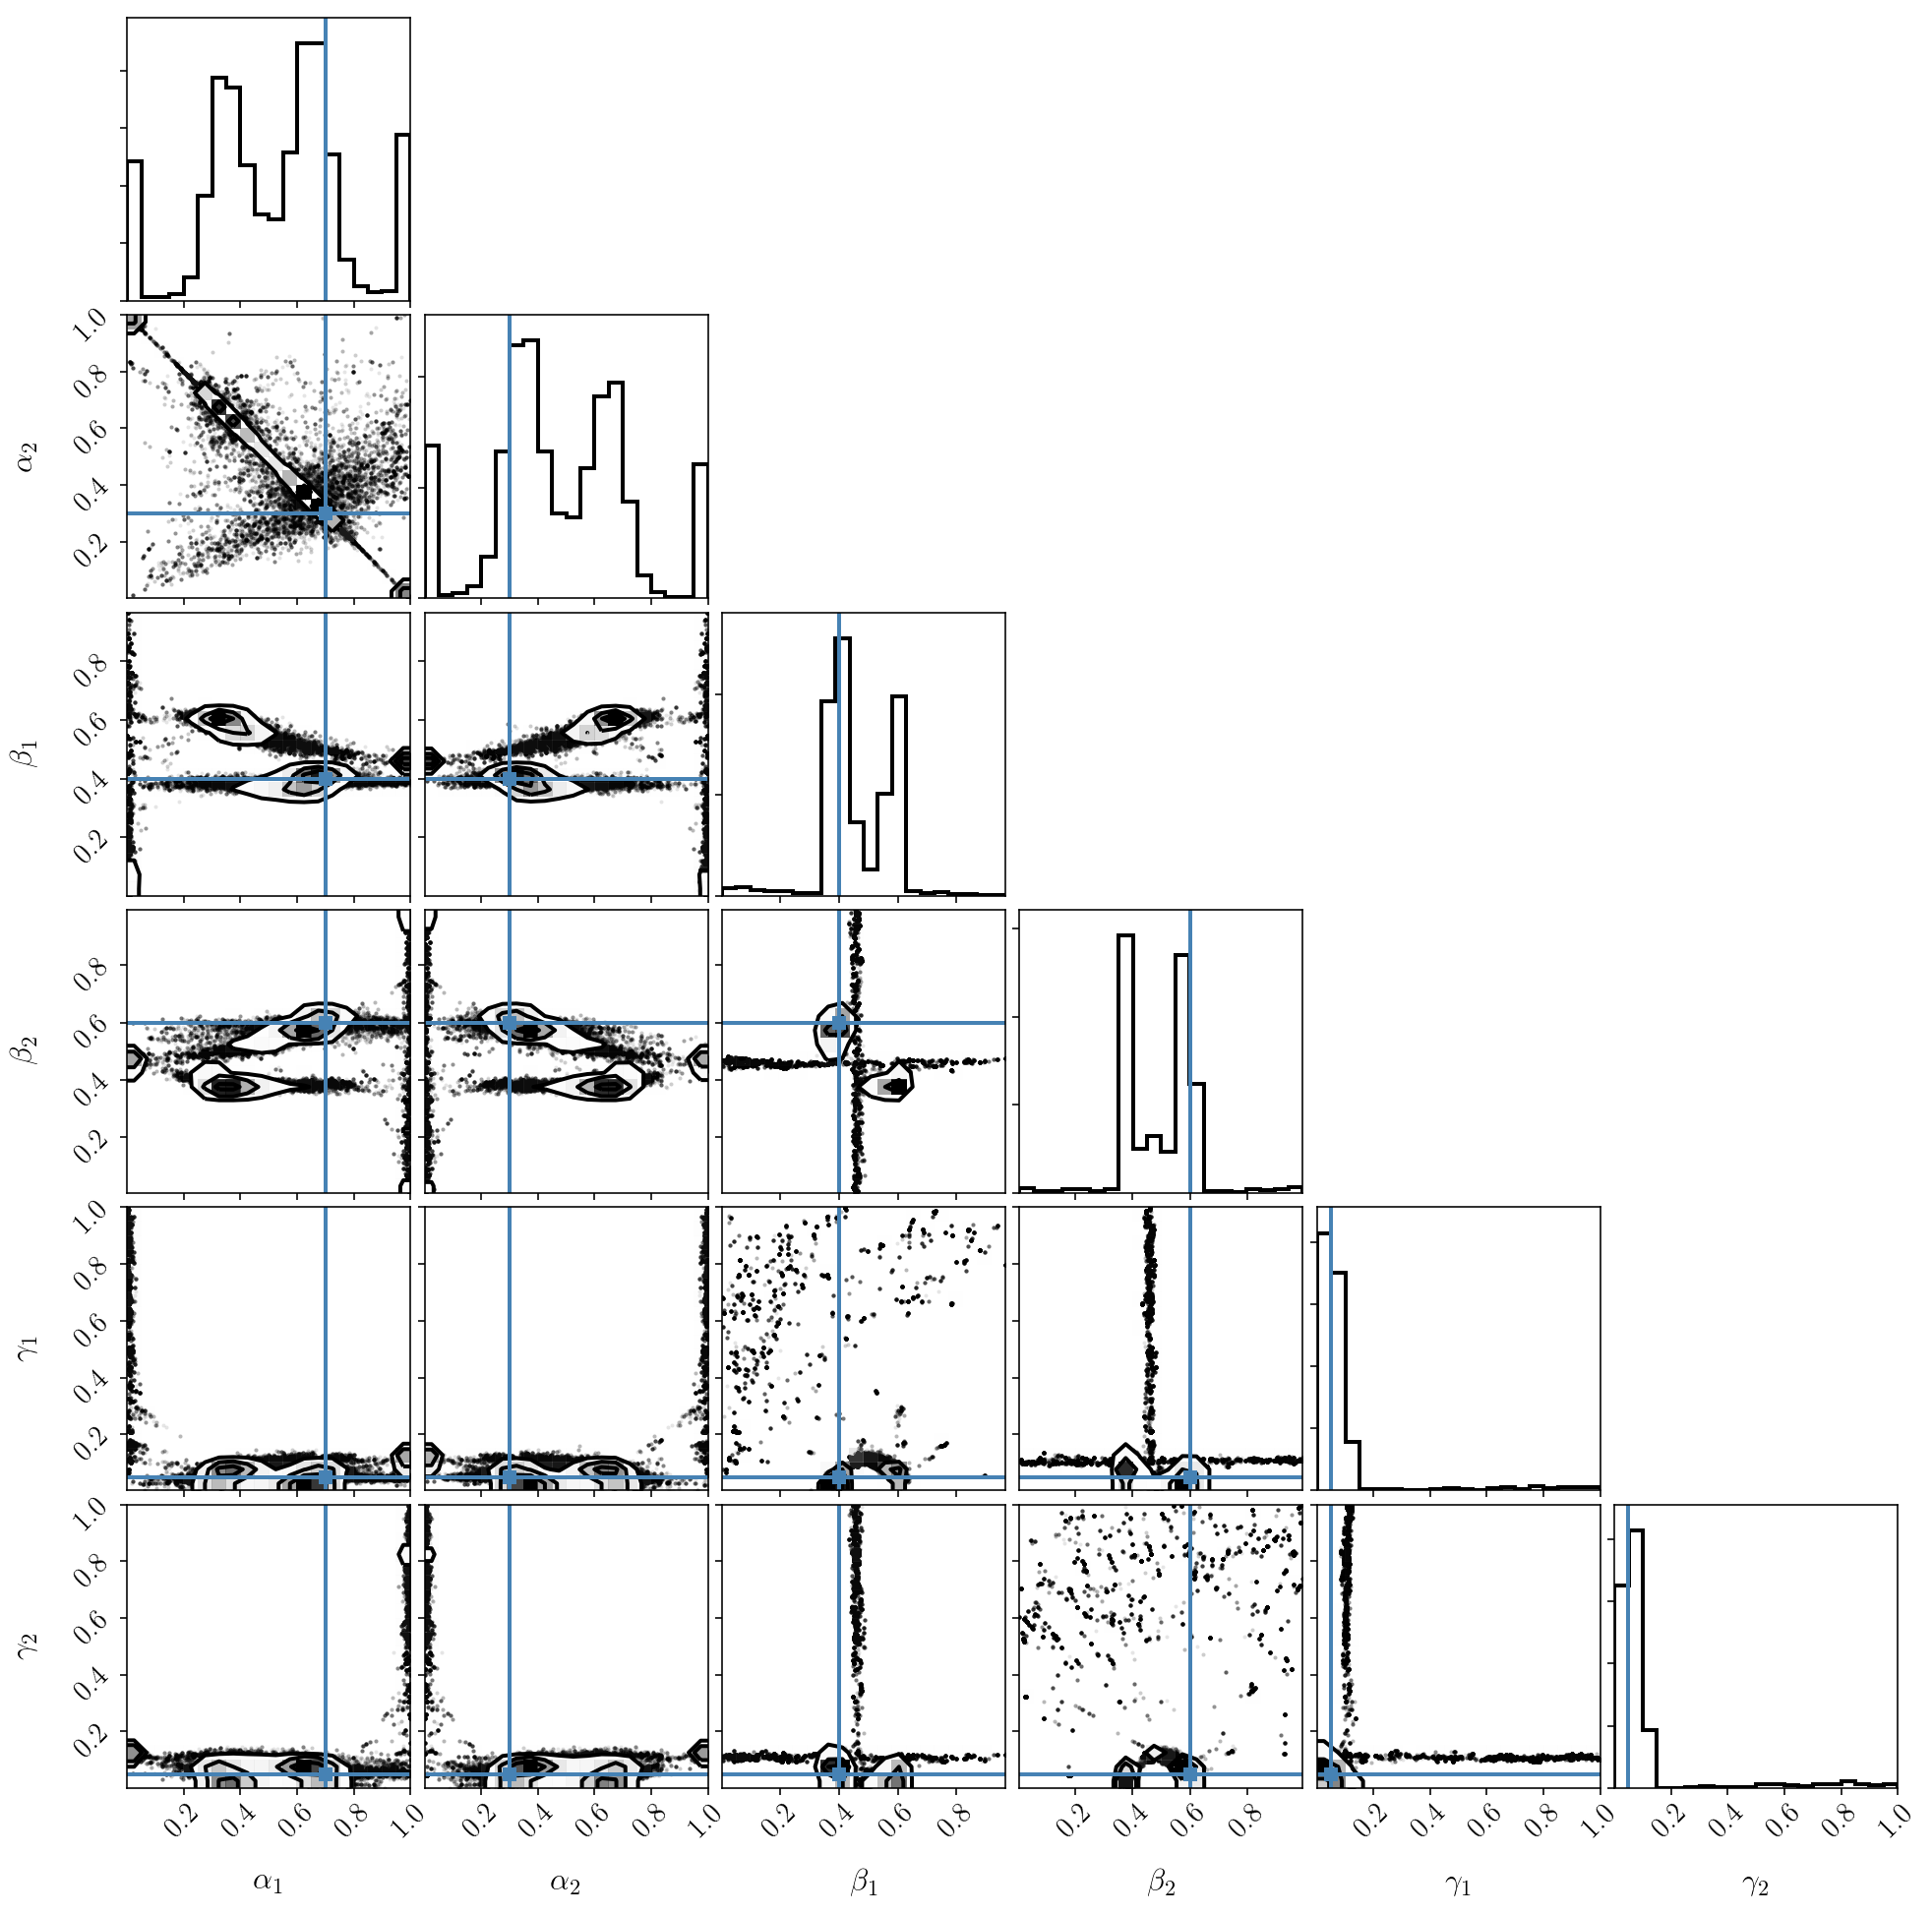

In [45]:
param_names = [r'$\alpha_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
_ = corner.corner(sampler.flatchain, truths=params, labels=param_names)

As we can see, the result is surprisingly nasty! In fact, running MCMC on this distribution is *incorrect*. The posterior distribution has strong degeneracies and is multimodal, so standard MCMC will not work. As an exercise, you can check that the sampler has not converged. Also, even if it looks like it is finding multiple modes, you can also check that the density of samples is incorrect at those locations, and is not proportional to the posterior distribution.

We briefly mentioned this phenomenon before. The degeneracy between $\alpha$'s is due to them being normalized and constrained to sum to one. As a result, the posterior distribution, by construction, live on a thin slice in $\alpha$ space. 

Among the many ways one could solve this problem this, that introduced by M. Betancourt (arxiv:1010.3436) is convenient and leads to simple derivatives. It establishes a bijective mapping between the $(B-1)-$ hypercube and the $B-$simplex, by constructing coefficients $z_i$'s with $0\leq z_i \leq 1$ for $i=1, \cdots, B-1$, and no normalization condition. The original coefficients on the simplex are found with

$\alpha_b = \prod_{i=1}^{b-1} z_i  \cdot \left\{\begin{array}{ll}1-z_b &\mathrm{if\ }b < B \\ 1 &\mathrm{if\ } b = B \end{array}\right.$

There are other possibilities for mapping the simplex onto closes volumes, but not all of them lead to simple derivatives (via a change of variable), which is often critical for some inference methods, like the HMC we will use later on.

Moreover, there is an additional complication that made our sampling failed: the labeling degeneracy. That is, we haven't imposed a specific order to the components, which means they can be swapped and lead to the same value of the posterior distribution. This degeneracy is well known and leads to a perfectly multimodal distribution (with $B!$ modes!). Since the mapping between those modes is known, simple solution is to tune the prior to only explore one of them. In one dimension, this can be achieved by enforcing the order of the components (for example their $\beta$'s) in the prior itself. Note that in multidimentional cases, this condition is more difficult to enforce.

## Second MCMC run: emcee with reparametrized model

We will now order the component locations and use the hypercube-to-simplex mapping to run the emcee sampler once again. We will also make some tighted assumptions about the component amplitudes and widths. We don't want those to be too small in order to avoid new sources of degeneracies in the posterior distribution. (This point will be illustrated in the next section). 

In [46]:
def lnprob(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    if np.any(zs < 0.1) or np.any(zs > 0.8):
        return -np.inf
    alphas = zs_to_alphas(zs)
    for i in range(nt-1): # We enforce an order to the components
        if betas[i] >= betas[i+1]:
            return -np.inf
    if np.any(params <= 0.0) or np.any(params >= 0.9):
        return -np.inf
    return - lnprob_hyperonly1(np.concatenate((alphas, params[nt-1:])))

params = np.concatenate([zs, betas, gammas])
ndim = params.size
nwalkers = ndim * 30
p0s = []
for i in range(nwalkers):
    lnp = -np.inf
    while ~np.isfinite(lnp):
        p0 = np.random.uniform(0.03, 0.9, ndim) 
        p0[nt-1:2*nt-1].sort()
        lnp = lnprob(p0)
    p0s += [p0]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
pos, prob, state = sampler.run_mcmc(p0s, 1000)
sampler.reset()
_ = sampler.run_mcmc(pos, 1000)

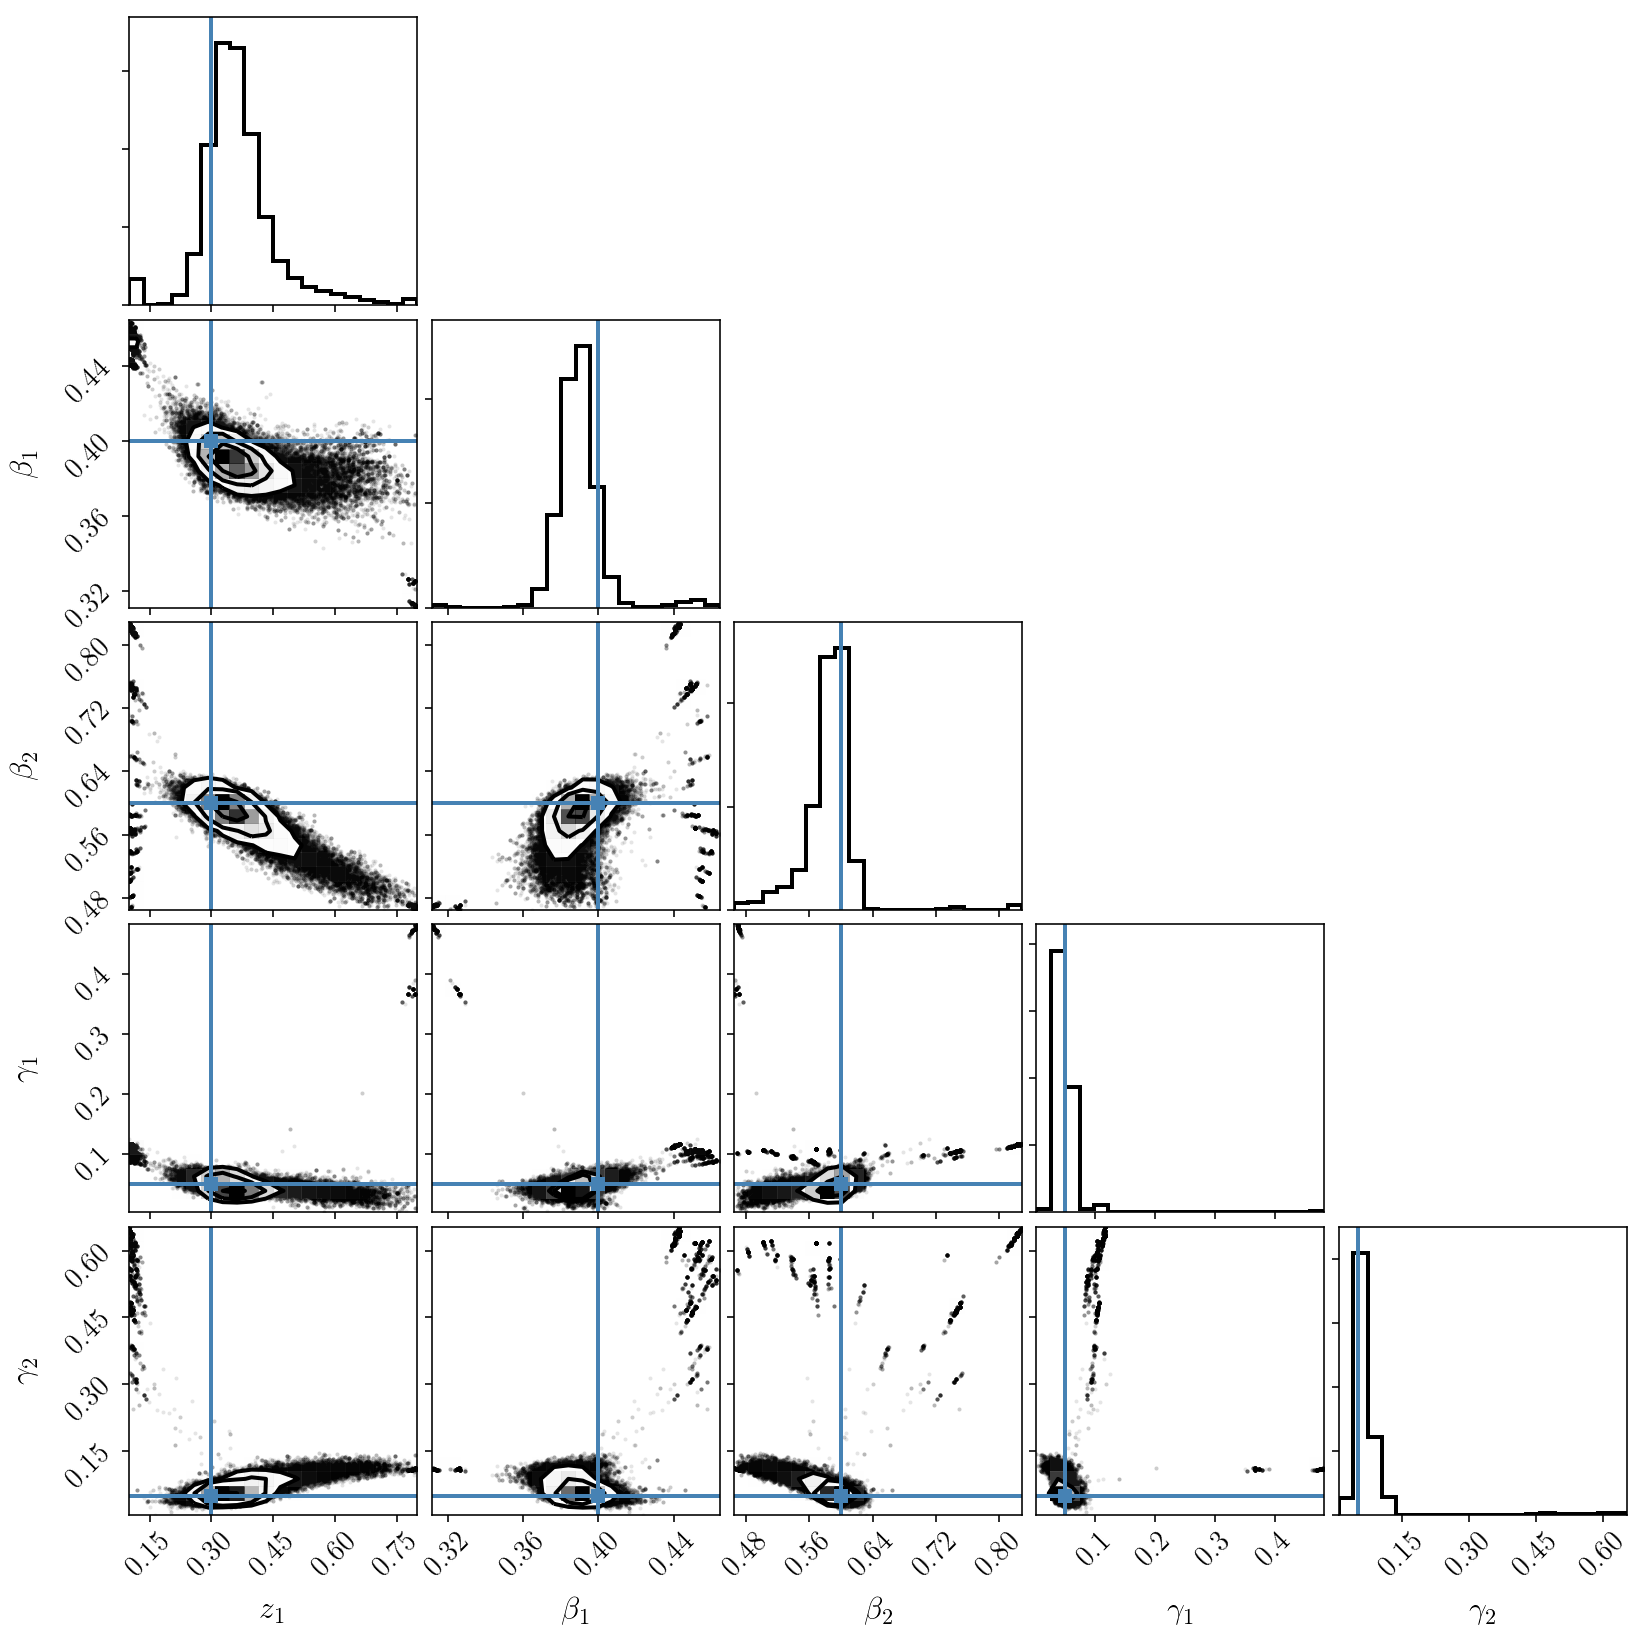

In [47]:
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
_ = corner.corner(sampler.flatchain, truths=params, labels=param_names)

We now see that we have solved those issues and that we obtain a nicely sampled unimodal posterior distribution, with the true values correctly included.

(If you see some strange tail and isolated samples that seem to indicate a secondary mode, please ignore this at the moment. This is real, and will be discussed later on.)

Note that our sampling procedure is very quick: the two runs merely took a few seconds. This is because emcee has many nice properties and is parallelized. Yet, as we will discuss below, more efficient approaches exist (in terms of the fraction of random proposed samples that are accepted), and those are essential for scaling up from a few parameters to... many millions!

A nice visualization of the result is in data space, where we evaluate our model for a few hundred samples of the posterior distribution, and see that they are nicely around the truth.

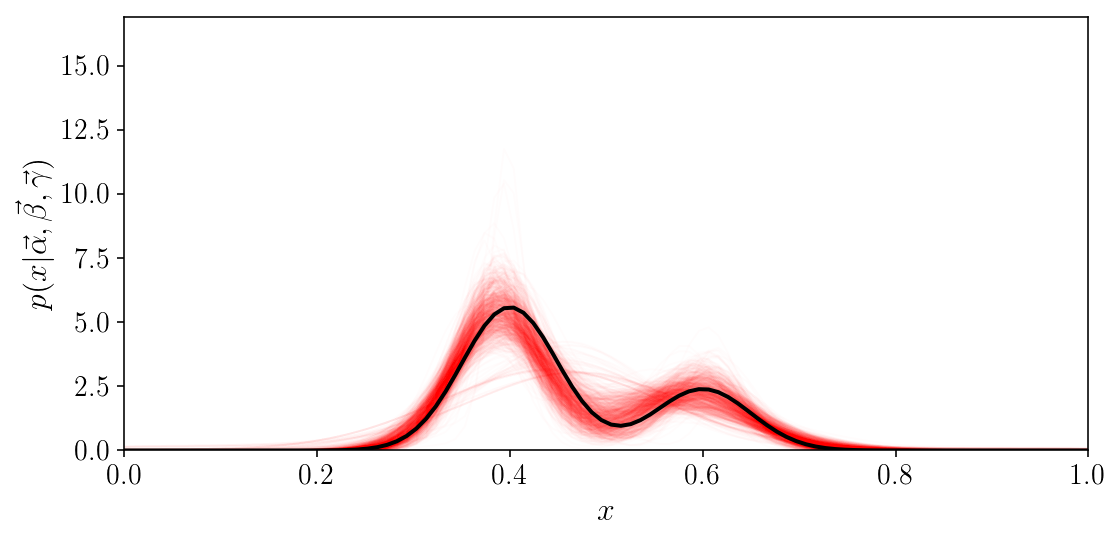

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in np.random.choice(sampler.flatchain.shape[0], 1000, replace=False):
    alphas2 = zs_to_alphas(sampler.flatchain[i, 0:nt-1])
    betas2 = sampler.flatchain[i, nt-1:2*nt-1]
    gammas2 = sampler.flatchain[i, 2*nt-1:3*nt-1]
    p_x_grid2 = alphas2[None, :] * np.exp(-0.5*((x_grid[:, None] - betas2[None, :])/gammas2[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas2[None, :]
    p_x_grid2 = np.sum(p_x_grid2, axis=1)
    ax.plot(x_grid, p_x_grid2, color='r', alpha=0.01, lw=1)
ax.plot(x_grid, p_x_grid[:, :].sum(axis=1), c='k')
ax.set_xlim([0, 1])
ax.set_ylim([0, axs[0].get_ylim()[1]*1.7])
ax.set_ylabel(r'$p(x|\vec{\alpha}, \vec{\beta}, \vec{\gamma})$')
ax.set_xlabel(r'$x$')
fig.tight_layout()

# Exploring the full posterior distribution with PolyChord

Let us now investigate and try to understand the structure of our full posterior distribution. We will use the simplex-to-hypercube mapping, but no longer order the components.

Standard MCMC techniques like Metropolis-Hasting or Ensemble approaches, in their standard implementations, will only correctly sample uni-modal distributions. Some of them can be extended to deal with multimodality. Yet, the most widespead solution for fully mapping a multimodal distribution is nested sampling. PolyChord is one of the most sophisticated implementations of this sampling scheme, and is able to accurately map very complicated distributions.

There is a cost: nested sampling typically requires many more function evaluations than standard MCMC, and also has a few parameters that need to be tuned. We will not cover that last point here, but you should know that running nested sampling may require some tuning via trial and error. Finally, we won't discuss or make use of the fact that nested sampling delivers the model evidence (or marginalized likelihood), which is essential for performing model comparison.

Let us run PolyChord on our data set, with the same posterior, no ordering constraints, and two components only.

In [49]:
# Save the data to numpy arrays since we will run polychord outside of this notebook.
np.save("yis", yis)
np.save("sigmais", sigmais)

In [50]:
# The code we will write to a file and execute to run PolyChord.
# the only parameter of this string is the number of components.
# the second string has a parameter for (de)activating the clustering algorith.
code1 = """
import numpy as np
import sys
sys.path.append('/Users/bl/Dropbox/software/PolyChord/PyPolyChord') # Put correct path here.
import PyPolyChord as PolyChord

nt = %i
ndim = 3*nt - 1
nderived = 0

yis = np.load("yis.npy")
sigmais = np.load("sigmais.npy")

def prior(cube):
    theta = [0.0] * ndim
    for i in range(nt):
        theta[i] = cube[i]
        theta[nt-1+i] = cube[nt-1+i]
        theta[2*nt-1+i] = 0.03 + 0.97 * cube[2*nt-1+i]
    return theta 

def mixturemodellnprob(params):

    phi = [0.0] * 0
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    fac = np.array([1.0]*nt)
    zsb = np.array([1.0]*nt)
    for i in range(nt-1):
        fac[i] = 1. - zs[i]
        zsb[i+1] = zs[i]
    alphas = np.cumprod(zsb) * fac
    
    like = 0.*yis
    for i in range(nt):
        sig = np.sqrt(gammas[i]**2. + sigmais[:]**2.)
        like += alphas[i] * np.exp(-0.5*((yis[:]-betas[i])/sig)**2.) / sig
    logL = np.sum(np.log(like))

    return logL, phi
"""
code2 = """
PolyChord.run_nested_sampling(mixturemodellnprob, ndim, nderived, prior=prior,
                              file_root='mixturemodellnprob', do_clustering=%s,
                              nlive=100*ndim, update_files=100*ndim, 
                              num_repeats=10*ndim, boost_posterior=5)
"""


In [51]:
text_file = open("run_PyPolyChord.py", "w")
text_file.write(code1 % 2 + code2 % True)
text_file.close()

# go in the terminal and run
# rm -rf chains ; mkdir chains ; mkdir chains/clusters ; python run_PyPolyChord.py
# If you get a segmentation fault, you'll need to compile PolyChord with extra flags
# to make sure the stack size is sufficient.

Let's visualize the posterior distribution. In this figure we will also plot all the ordering permutations of our true parameter values.

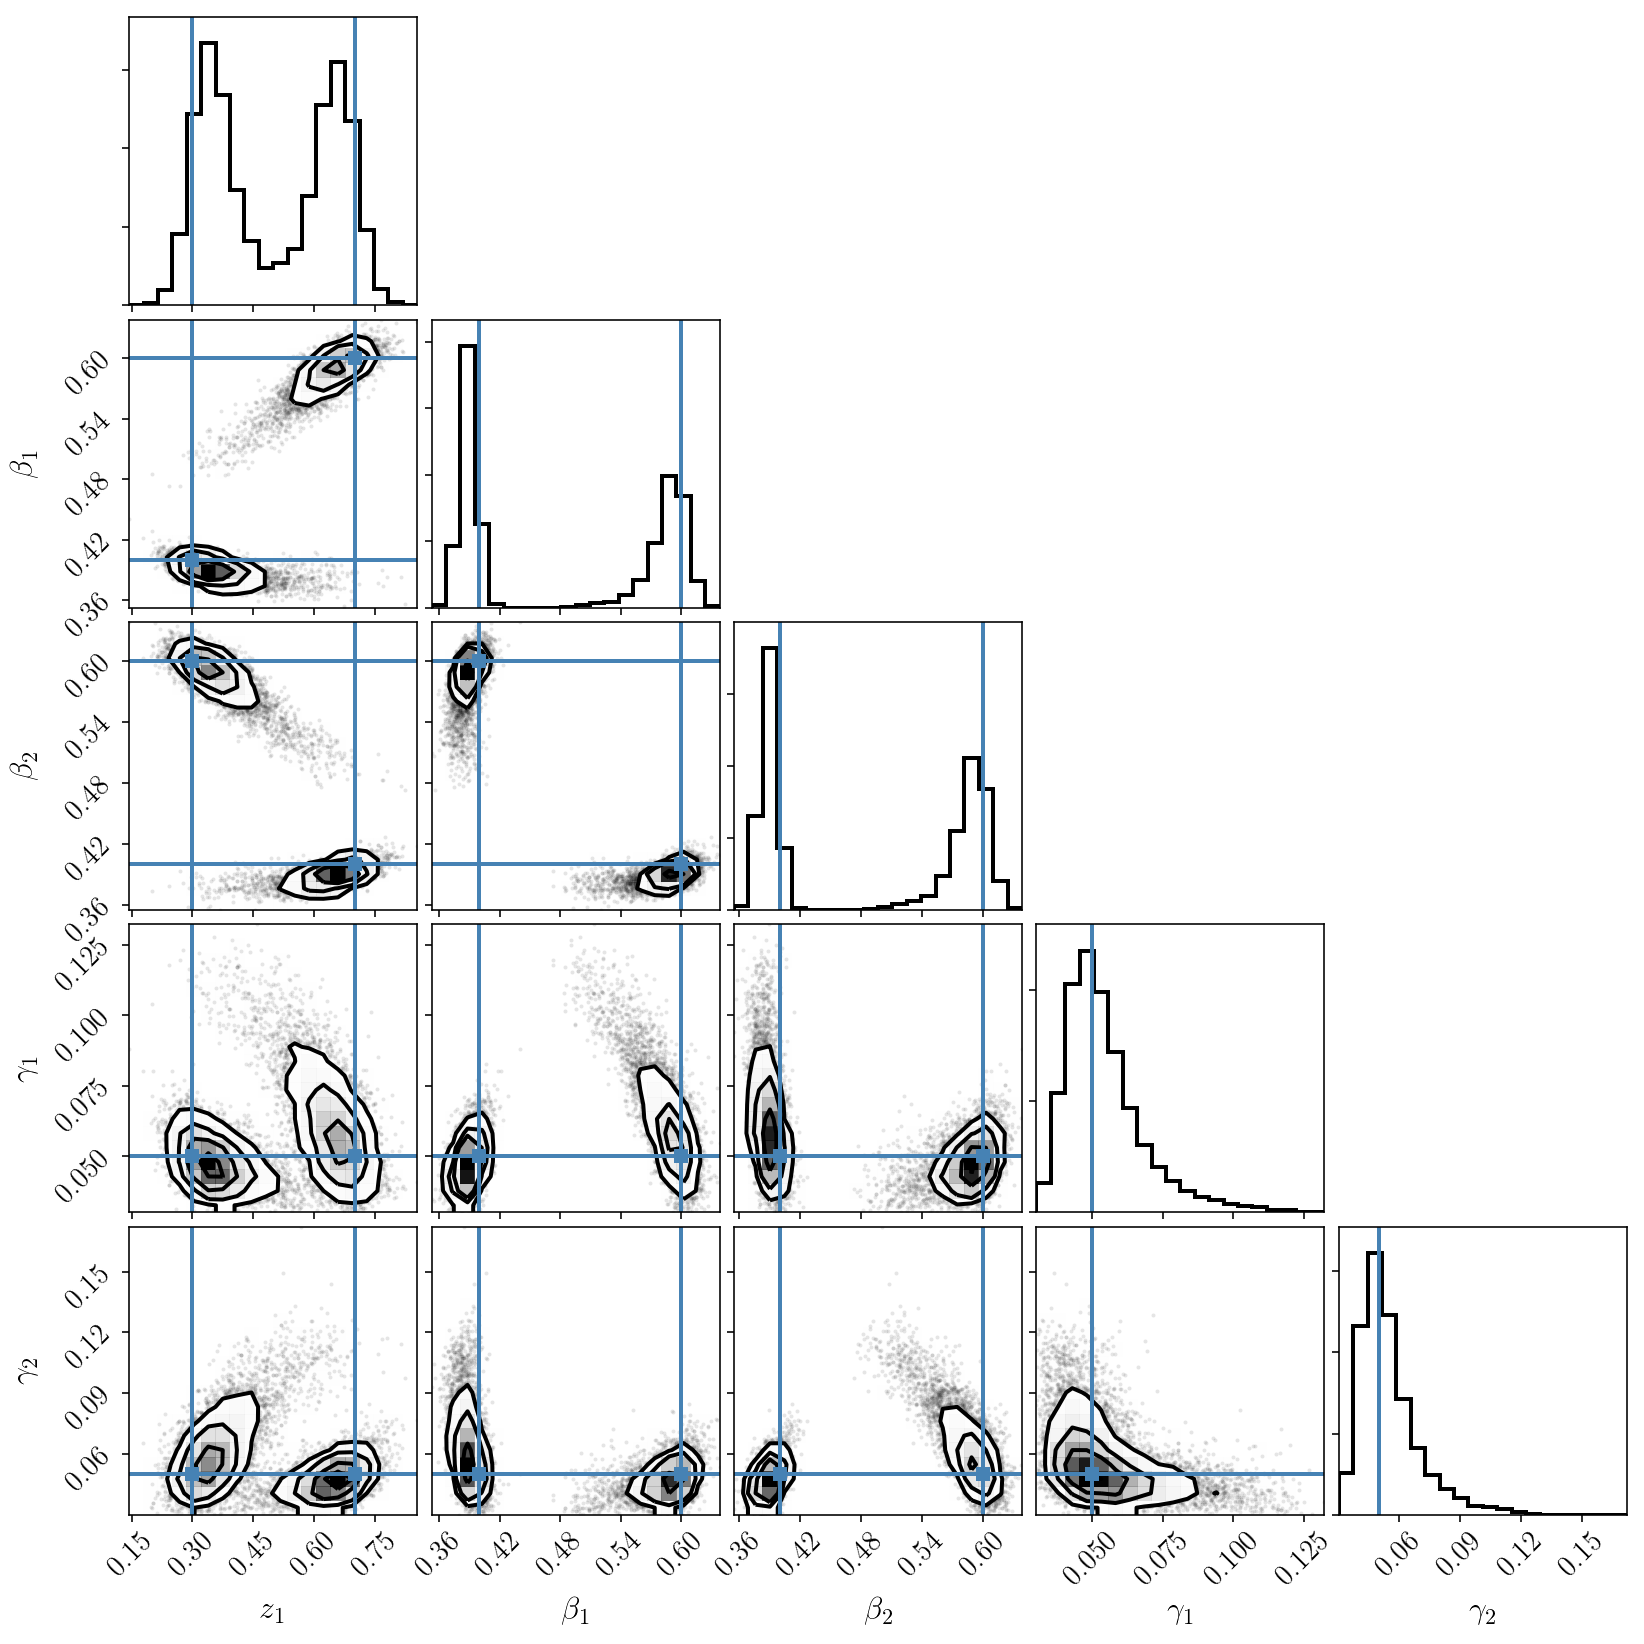

In [52]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
fig = corner.corner(samples[:, 2:], ranges=[[0, 1]*(3*nt-1)], labels=param_names)
#samples = np.genfromtxt('chains/mixturemodellnprob_phys_live.txt')
#fig = corner.corner(samples[:, :-1]) # If you want to plot the live points while PolyChord runs.
axs = np.array(fig.axes).reshape((3*nt - 1, 3*nt - 1))
for ind in itertools.permutations(range(nt)):
    order = np.array(ind)
    truths = np.concatenate((alphas_to_zs(alphas[order]), betas[order], gammas[order]))
    for i in range(3*nt - 1):
        axs[i, i].axvline(truths[i], c="#4682b4")
        for j in range(i):
            axs[i, j].axhline(truths[i], c="#4682b4")
            axs[i, j].axvline(truths[j], c="#4682b4")
            axs[i, j].plot(truths[j], truths[i], "s", color="#4682b4")

We can now see the two modes caused by the labelling degeneracy! PolyChord nicely finds and map them. Since we have activated the clustering algorithm, we can restrict our attention to one of the modes and plot posterior samples. Indeed, we check that our inference is correct.

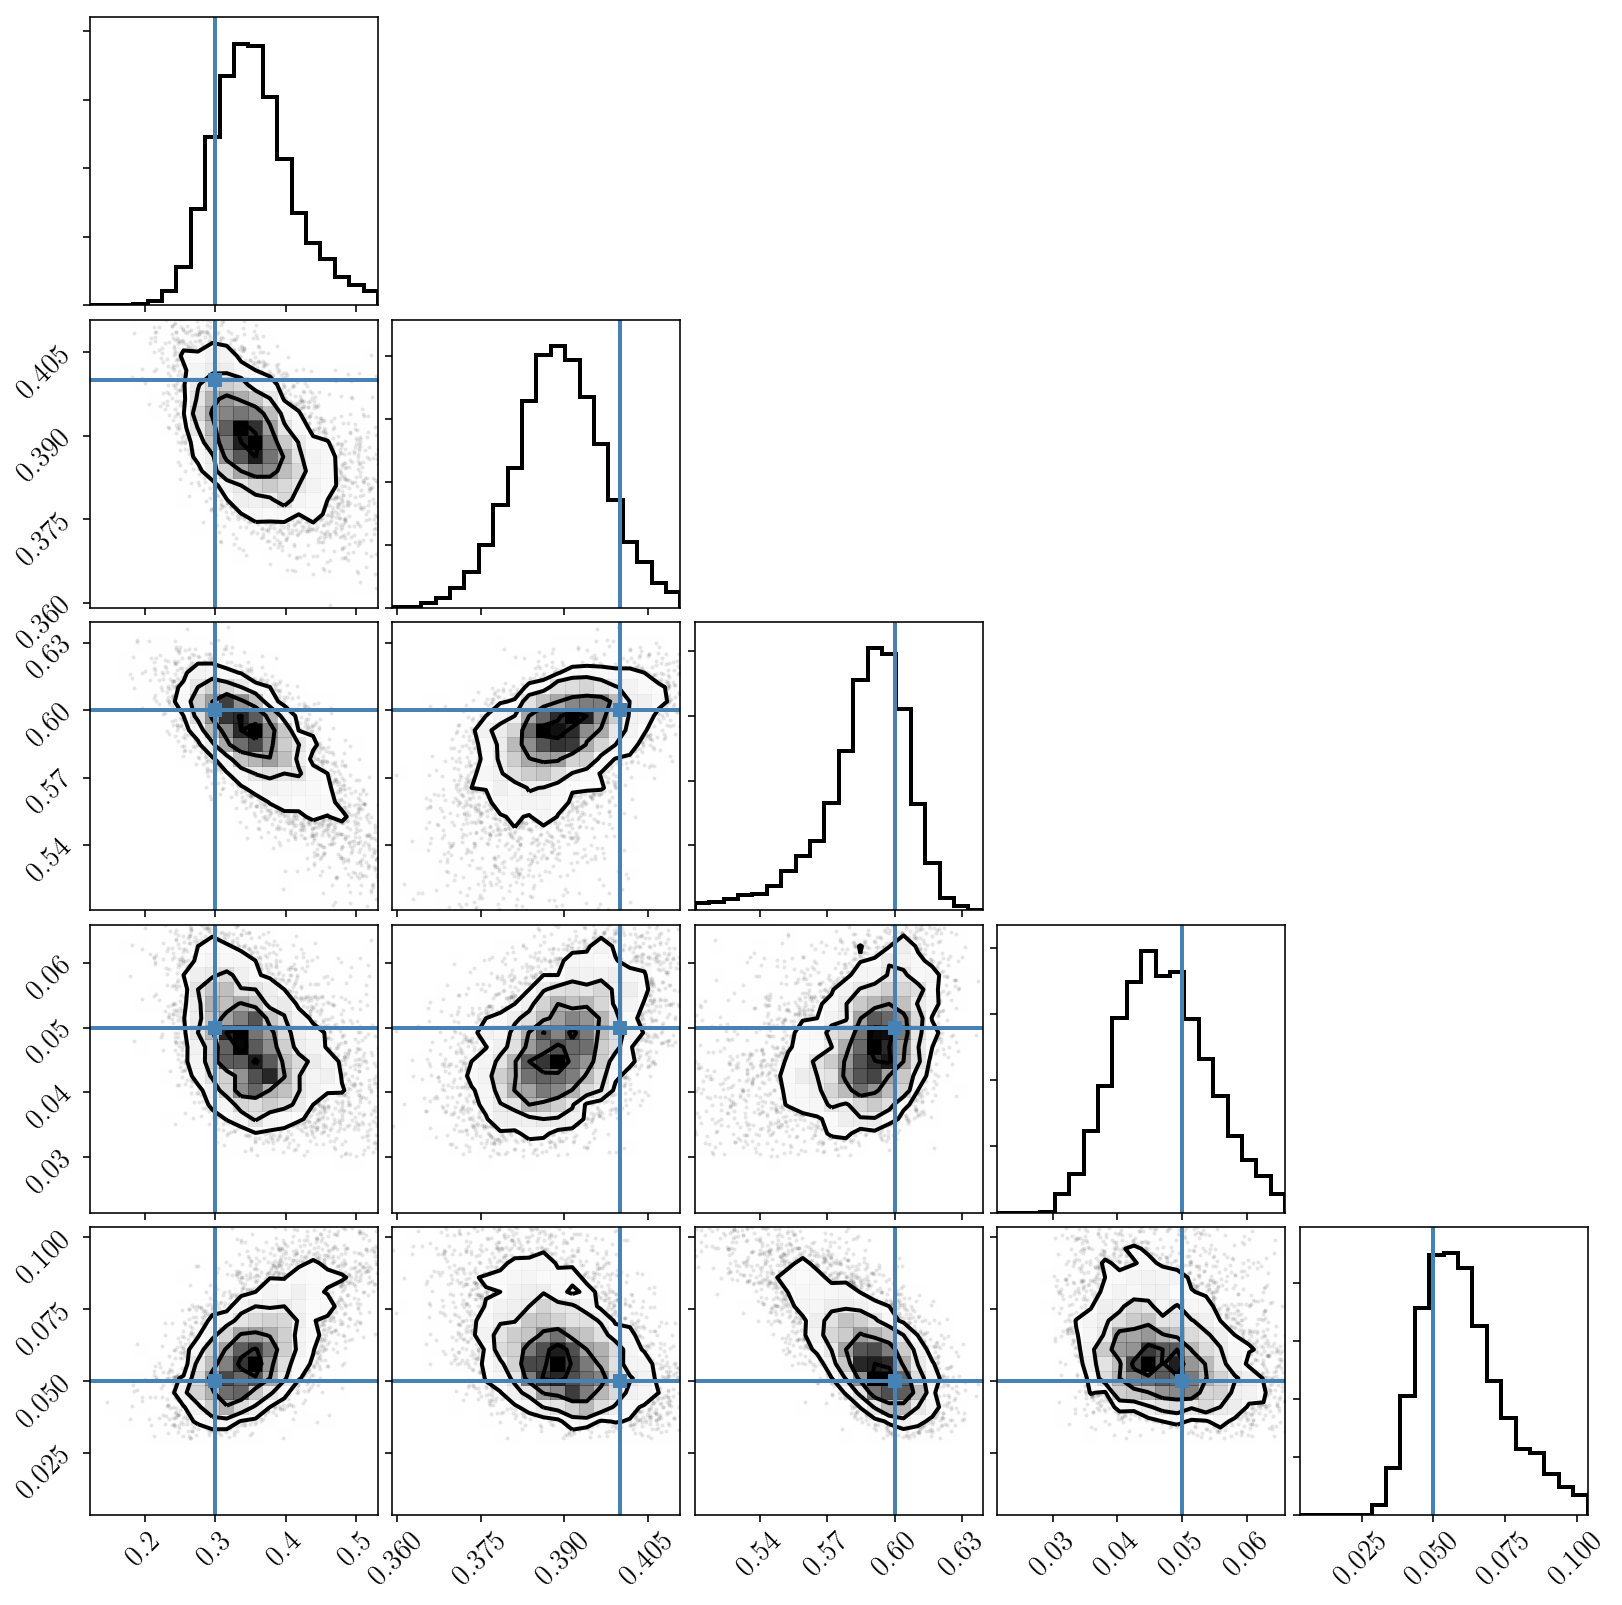

In [53]:
samples = np.genfromtxt('chains/clusters/mixturemodellnprob_1_equal_weights.txt')
mus = np.mean(samples[:, 2:], axis=0)
sigs = np.std(samples[:, 2:], axis=0)
ranges = [[mu-3.5*sig, mu+2.5*sig] for mu, sig in zip(mus, sigs)]
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
fig = corner.corner(samples[:, 2:], range=ranges, labls=param_names)
axs = np.array(fig.axes).reshape((3*nt - 1, 3*nt - 1))
for ind in itertools.permutations(range(nt)):
    order = np.array(ind)
    truths = np.concatenate((alphas_to_zs(alphas[order]), betas[order], gammas[order]))
    for i in range(3*nt - 1):
        axs[i, i].axvline(truths[i], c="#4682b4")
        axs[i, i].set_xlim(ranges[i])
        for j in range(i):
            axs[i, j].axhline(truths[i], c="#4682b4")
            axs[i, j].axvline(truths[j], c="#4682b4")
            axs[i, j].plot(truths[j], truths[i], "s", color="#4682b4")
            axs[i, j].set_xlim(ranges[j])
            axs[i, j].set_ylim(ranges[i])

You may wonder, since the mapping between the two modes is predictable, why we don't simply post-process the chains to order the components and manually merge the modes? This is indeed a very good solution to return to a unimodal case. Unsurprisingly, it is more sampled that the plot we just made with PolyChord's solution for a single cluster, since we've just merged all the clusters by reordering.

Note that this trick must be very carefully applied. One cannot just post-processed any MCMC chain to alleviate the multimodality problem (for mixture models only!). This will only work if the MCMC sampler has converged and properly explored the multiple modes it has mapped (though it is insensitive the the relative amplitudes in this exploration, for obvious geometrical reasons). In our case this is valid.

In [54]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
unordered_samples = samples[:, 2:]
ordered_samples = np.zeros((unordered_samples.shape[0], unordered_samples.shape[1]))
for i in range(unordered_samples.shape[0]):
    thealphas = zs_to_alphas(unordered_samples[i, 0:nt-1])
    thebetas = unordered_samples[i, nt-1:2*nt-1]
    thegammas = unordered_samples[i, 2*nt-1:3*nt-1]
    order = np.argsort(thebetas)
    ordered_samples[i, 0:nt-1] = alphas_to_zs(thealphas[order])
    ordered_samples[i, nt-1:2*nt-1] = thebetas[order]
    ordered_samples[i, 2*nt-1:3*nt-1] = thegammas[order]

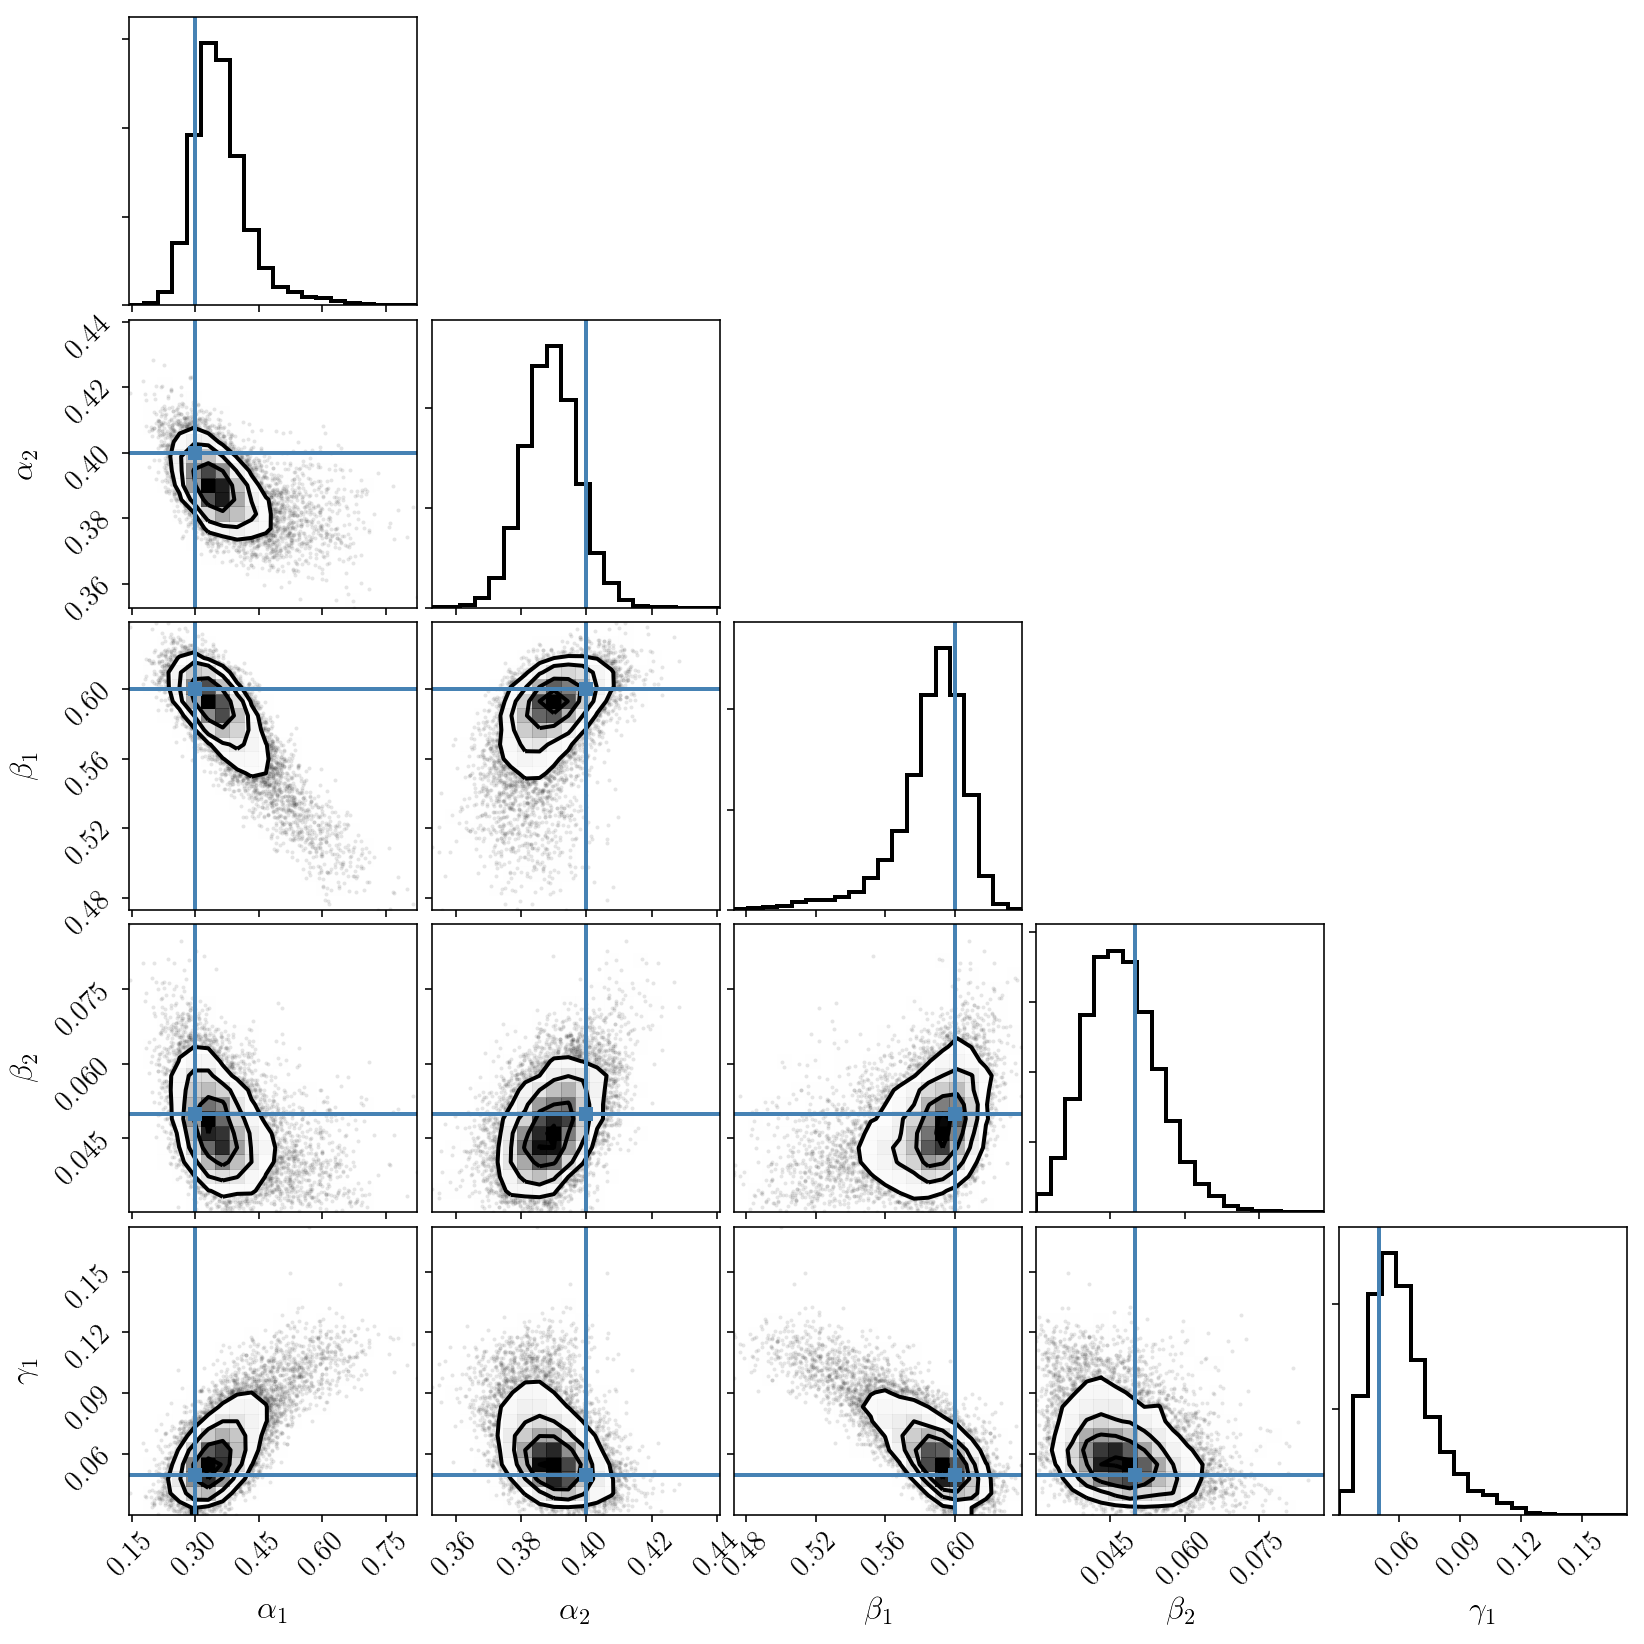

In [55]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
truths = np.concatenate((zs, betas, gammas))
param_names = [r'$\alpha_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]
fig = corner.corner(ordered_samples, labels=param_names, truths=truths)

Note that this PolyChord run took a few minutes. This is because nested sampling is generally calls the posterior distribution more times than MCMC, and our calls were not parallelized here. We have also tuned the parameters to sample the posterior distribution in a conservative fashion. One could certainly find better parameters that lead to a more efficient sampling. 

Let's do a more difficult run: perform the inference via PolyChord and three components instead of two. What will we see? Unfortunately, this run will be even slower and take several minutes, but the comments above apply again: this could be made more efficient if necessary.

In [56]:
nt2 = 3
text_file = open("run_PyPolyChord.py", "w")
text_file.write(code1 % nt2 + code2 % False) # run without clustering to speed it up.
text_file.close()

# go in the terminal and run
# rm -rf chains ; mkdir chains ; mkdir chains/clusters ; python run_PyPolyChord.py
# If you get a segmentation fault, you'll need to compile PolyChord with extra flags
# to make sure the stack size is sufficient.

If we plot the posterior distribution, we immediately see that the labeling degeneracy has gotten worse (since it scales as $B!$), and that the two-component model is clearly preferred (we nicely recover our input parameters). In other words, one of the components is constrained to be zero.

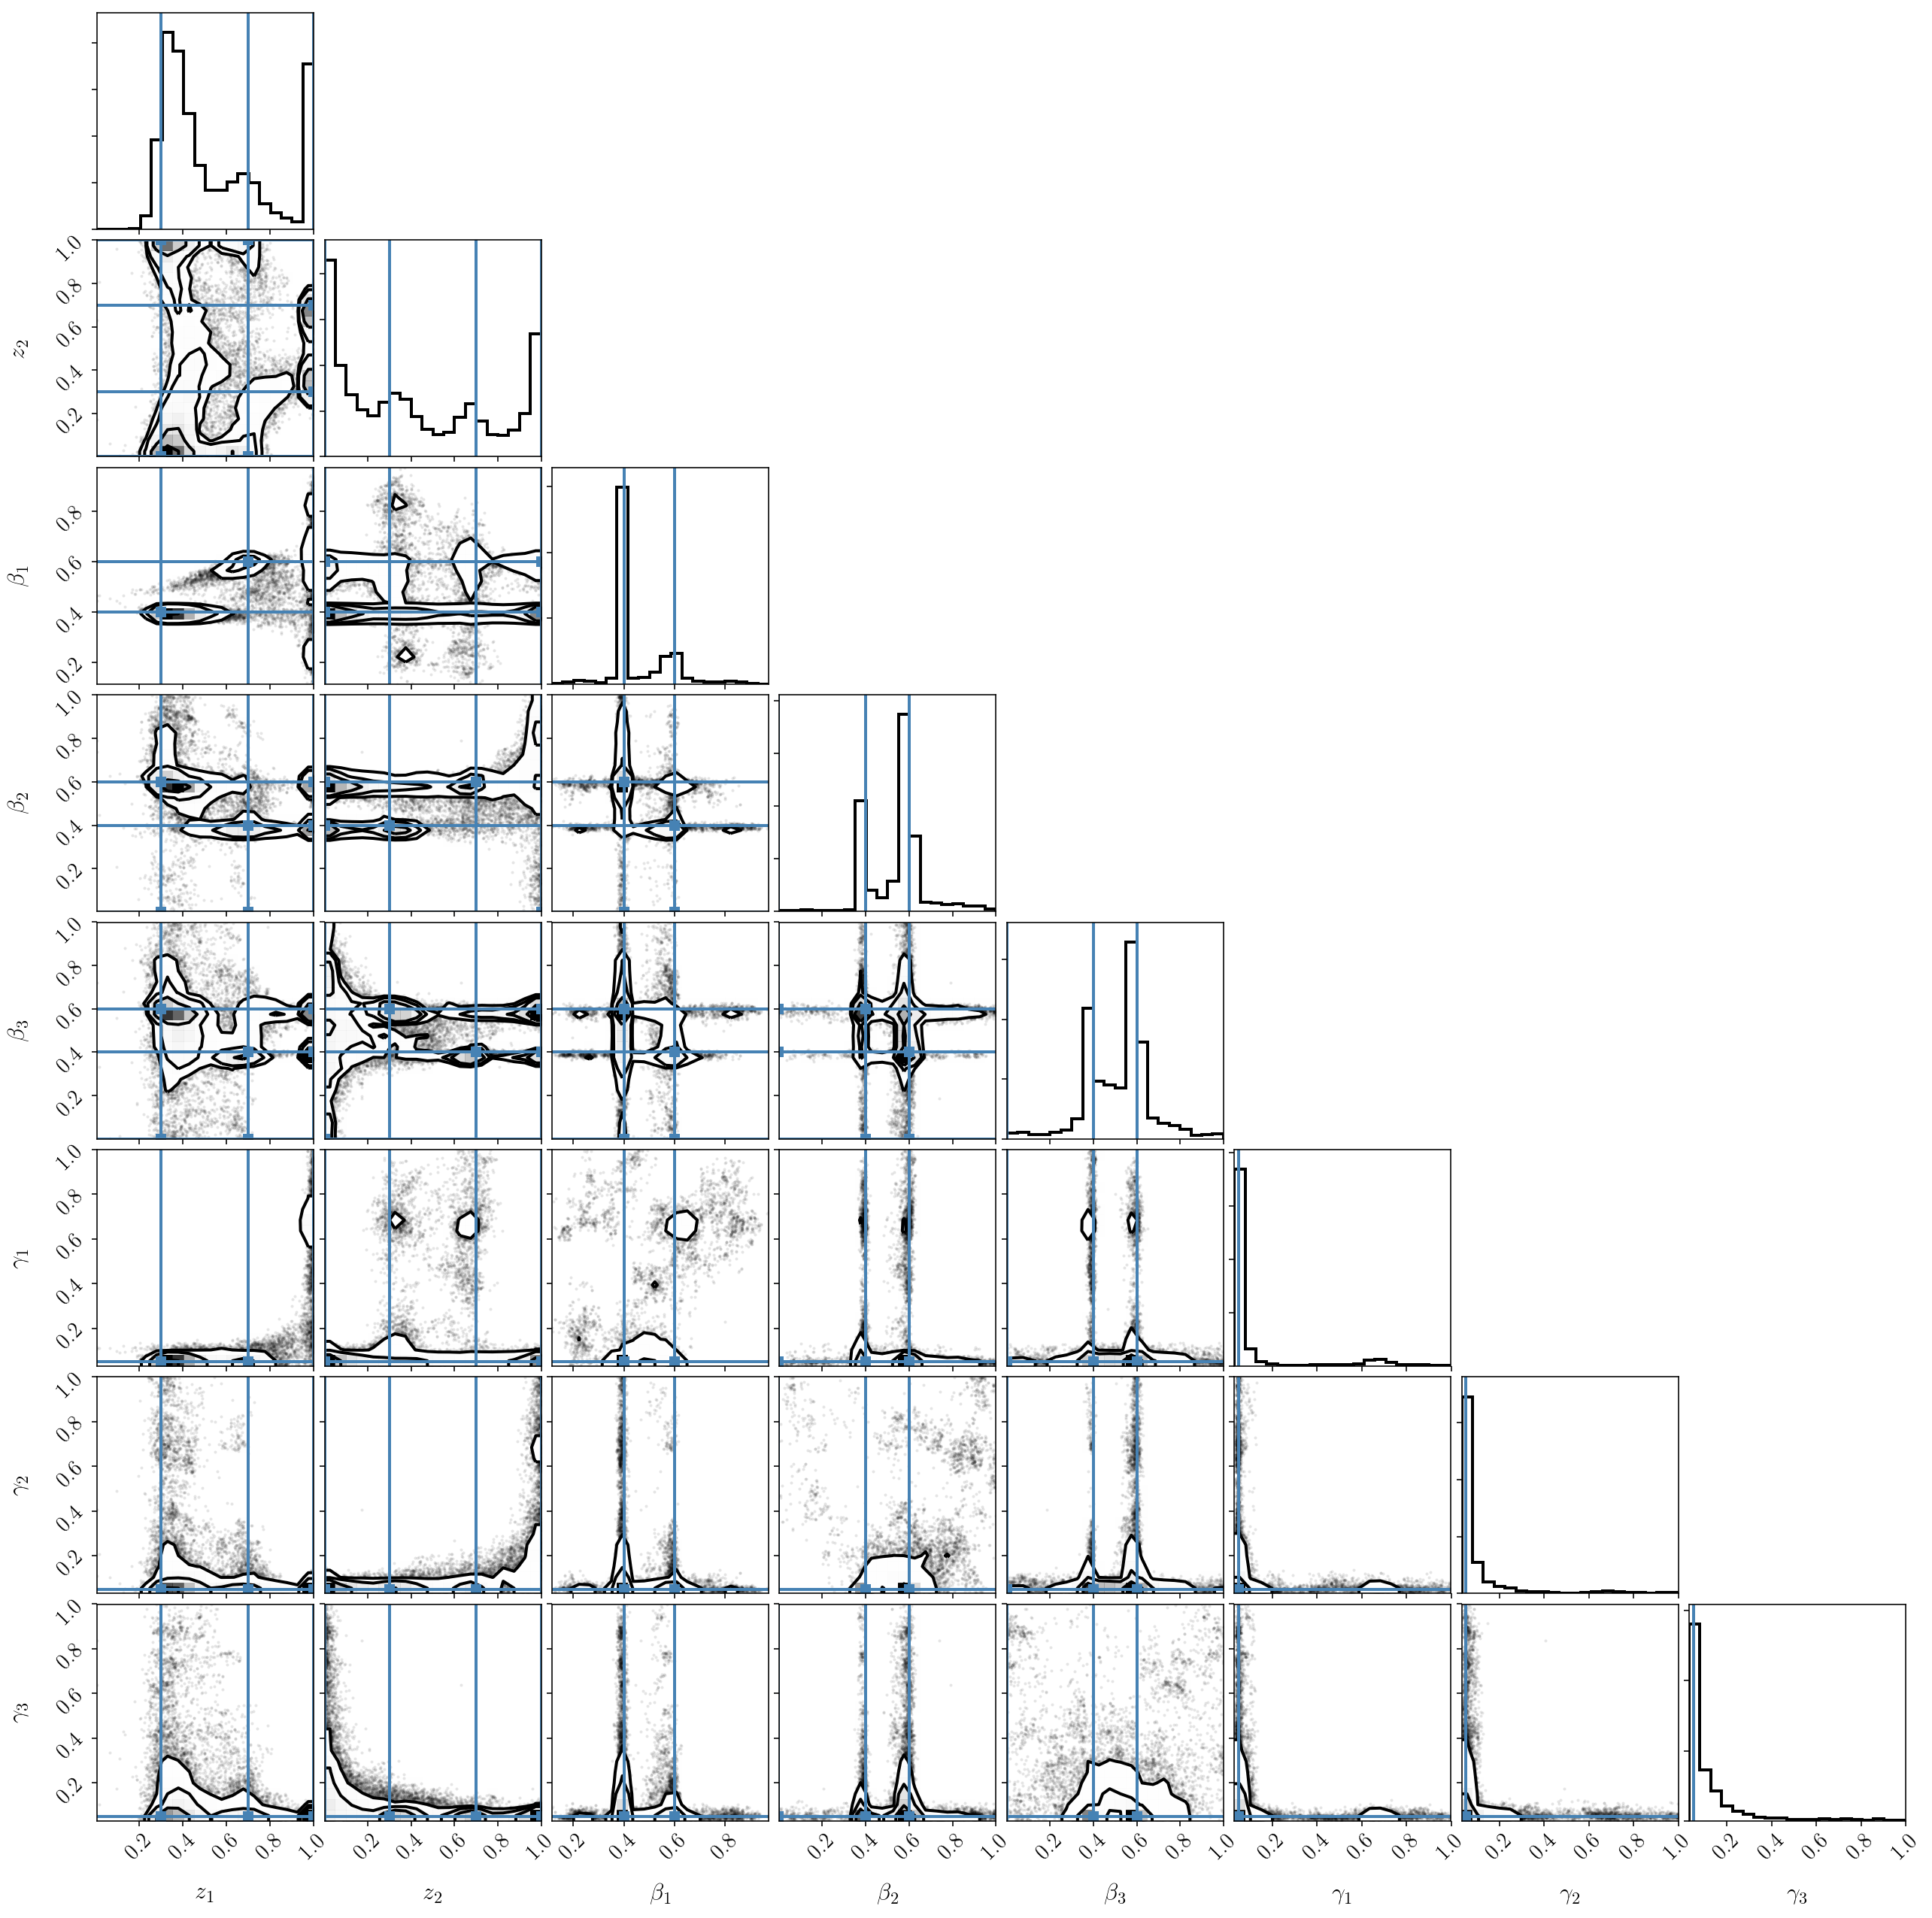

In [57]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt2-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt2)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt2)]
fig = corner.corner(samples[:, 2:], ranges=[[0, 1]*(3*nt2-1)], labels=param_names)
#samples = np.genfromtxt('chains/mixturemodellnprob_phys_live.txt')
#fig = corner.corner(samples[:, :-1]) # If you want to plot the live points while PolyChord runs.
axs = np.array(fig.axes).reshape((3*nt2 - 1, 3*nt2 - 1))
alphas2 = np.concatenate((alphas, np.repeat(0.00, nt2-nt)))
betas2 = np.concatenate((betas, np.repeat(0.00, nt2-nt)))
gammas2 = np.concatenate((gammas, np.repeat(0.00, nt2-nt)))
for ind in itertools.permutations(range(nt2)):
    order = np.array(ind)
    truths = np.concatenate((alphas_to_zs(alphas2[order]), betas2[order], gammas2[order]))
    for i in range(3*nt2 - 1):
        axs[i, i].axvline(truths[i], c="#4682b4")
        for j in range(i):
            axs[i, j].axhline(truths[i], c="#4682b4")
            axs[i, j].axvline(truths[j], c="#4682b4")
            axs[i, j].plot(truths[j], truths[i], "s", color="#4682b4")

If we try the previous trick and post-process the chains to reorder the components, we see that the result is not satisfactory at all! This is because the parameters of the third (small) component are unconstrained because it doesn't fit the data. It ends up interfering with the two others. 

Unfortunately, we can only conclude that the labeling degeneracy is not that easily killed. We have seen that nested sampling is a natural solution to map out the full posterior distribution. But isn't there another way to do standard MCMC and map a single of the modes? This is what we will do now with HMC.

In [72]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
unordered_samples = samples[:, 2:]
ordered_samples = np.zeros((unordered_samples.shape[0], unordered_samples.shape[1] + 1))
for i in range(unordered_samples.shape[0]):
    thealphas = zs_to_alphas(unordered_samples[i, 0:nt2-1])
    thebetas = unordered_samples[i, nt2-1:2*nt2-1]
    thegammas = unordered_samples[i, 2*nt2-1:3*nt2-1]
    order = np.argsort(thebetas)
    ordered_samples[i, 0:nt2] = thealphas[order]
    ordered_samples[i, nt2:2*nt2] = thebetas[order]
    ordered_samples[i, 2*nt2:3*nt2] = thegammas[order]

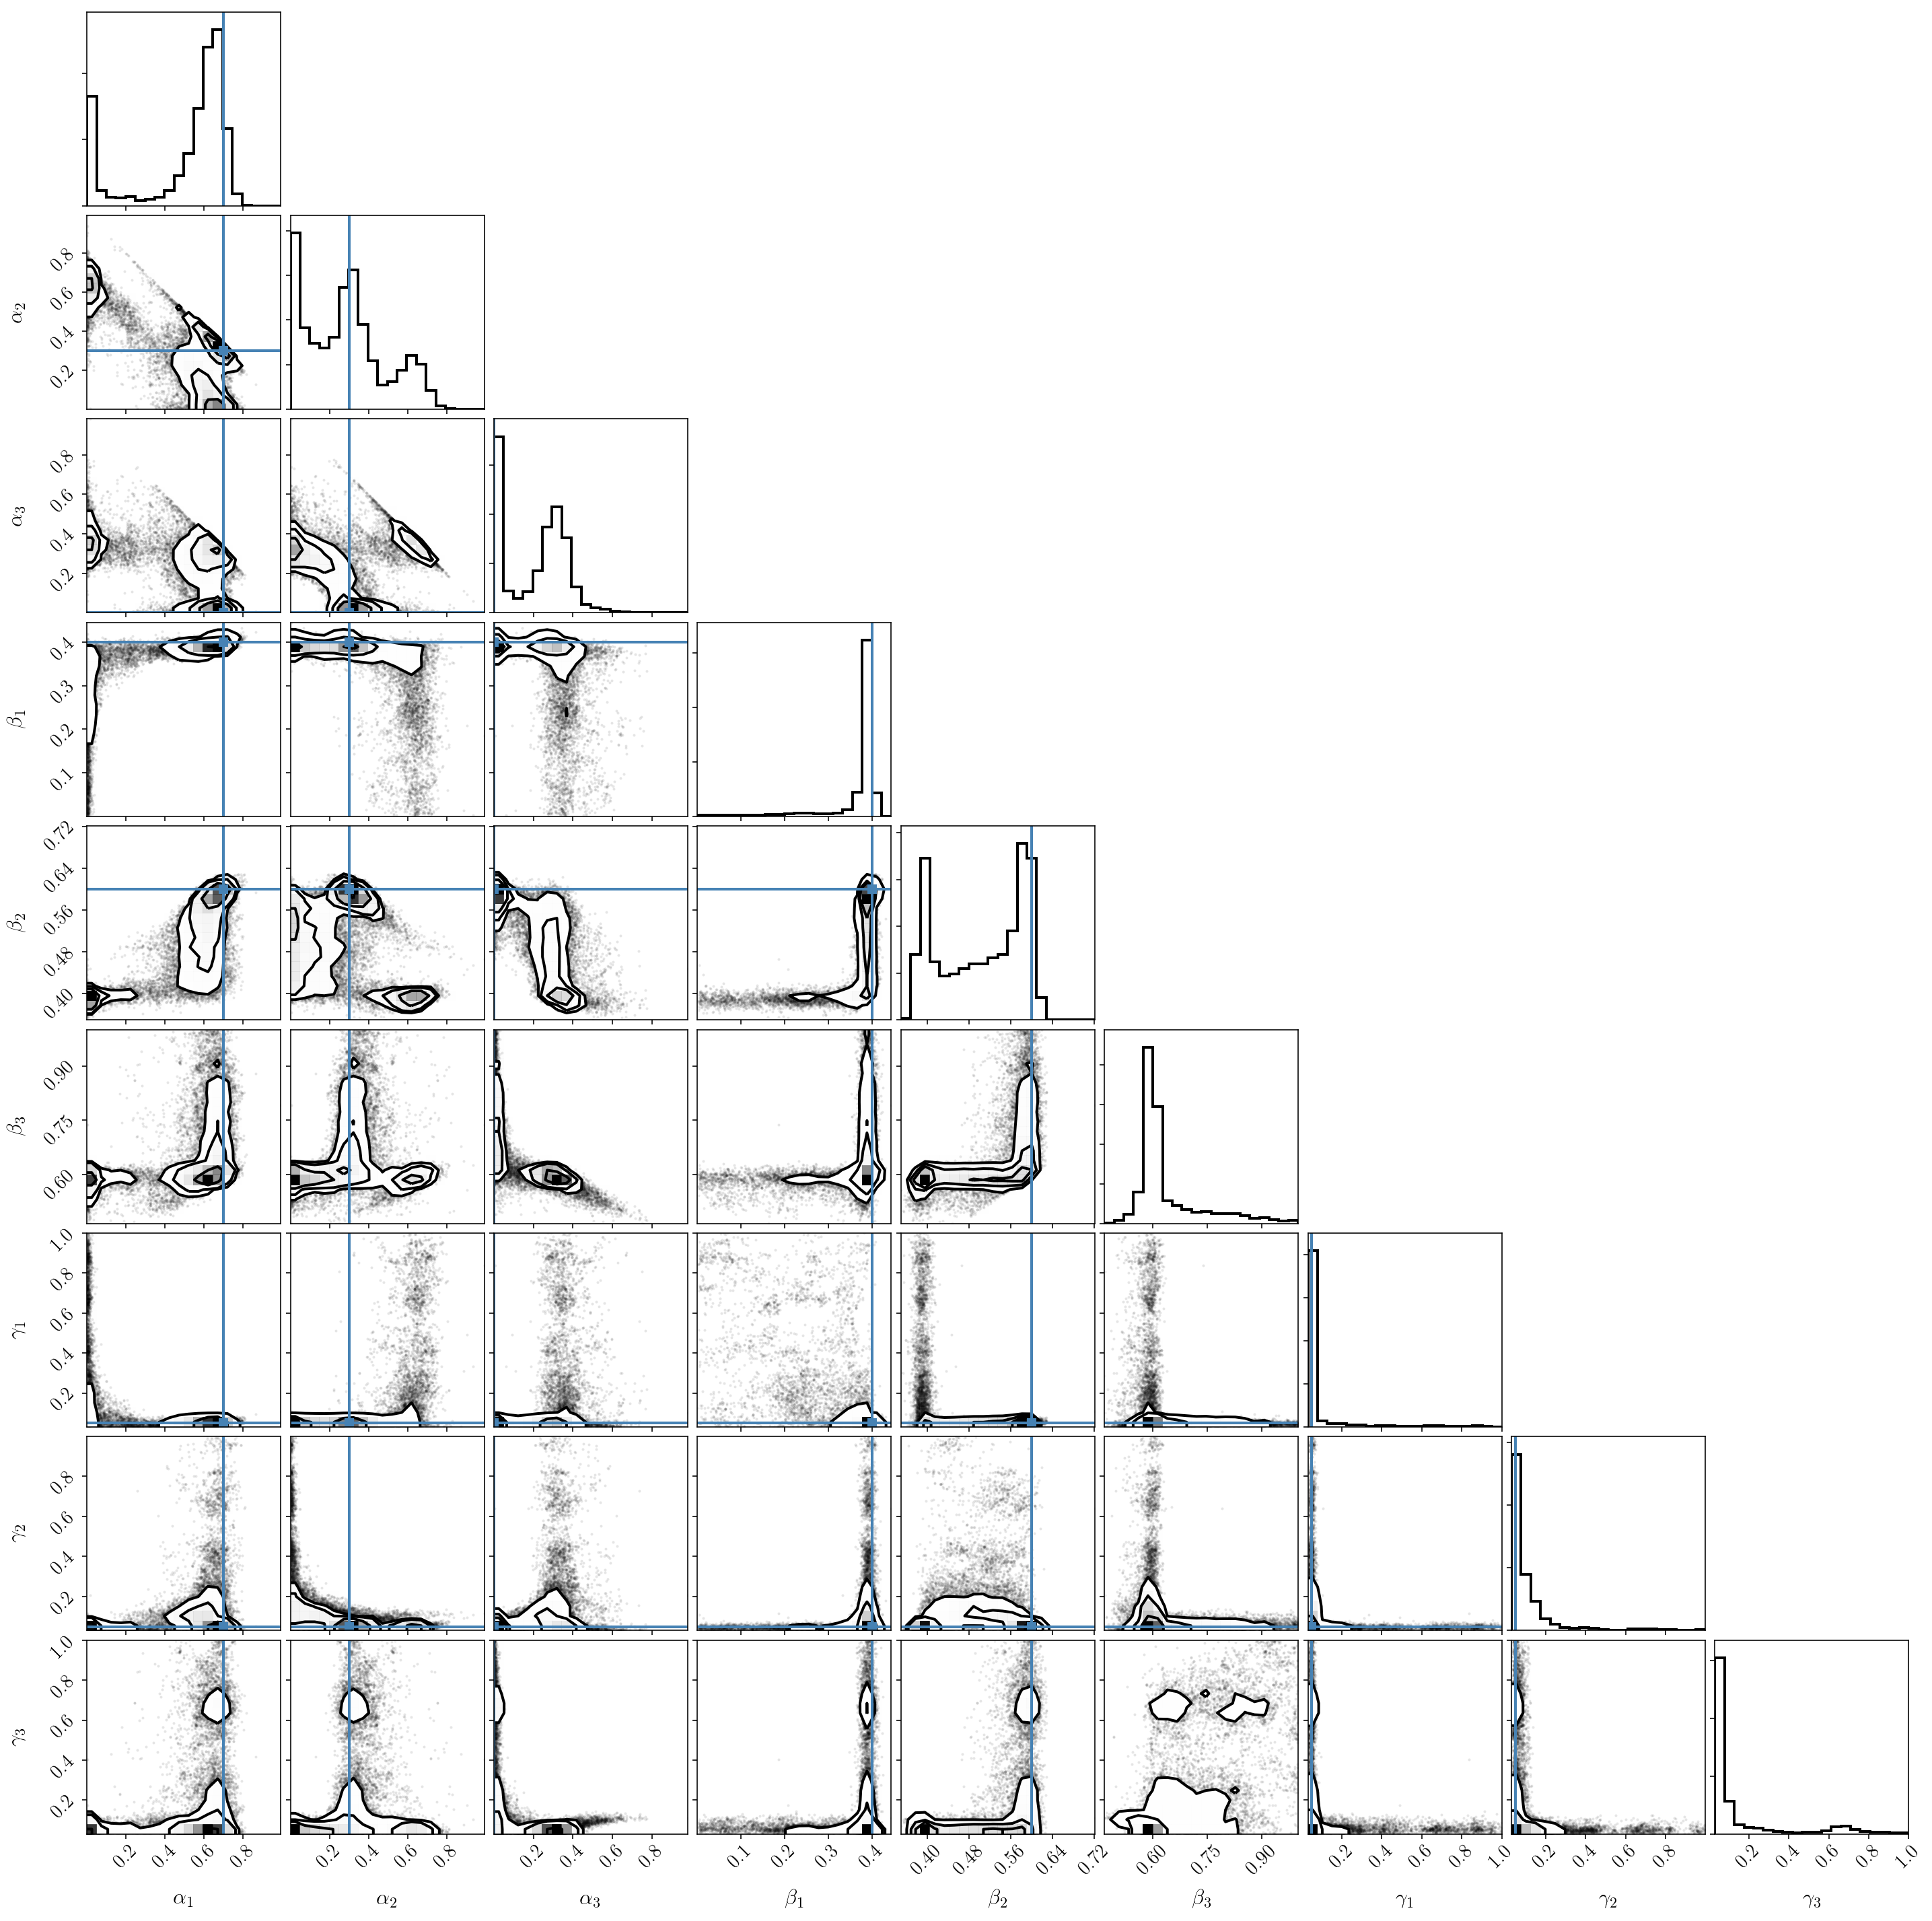

In [74]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')
alphas2 = np.concatenate((alphas, np.repeat(0.00, nt2-nt)))
betas2 = np.concatenate((betas, np.repeat(0.00, nt2-nt)))
gammas2 = np.concatenate((gammas, np.repeat(0.00, nt2-nt)))
truths = np.concatenate((alphas2, betas2, gammas2))
param_names = [r'$\alpha_'+str(i+1)+'$' for i in range(nt2)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt2)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt2)]
fig = corner.corner(ordered_samples, labels=param_names, truths=truths)

## HMC with automatic differentiation

On top of our wish to efficiently sample one single mode of the posterior distribution, let's return to a comment we made at the start: there are few real-world situations where the population and likelihood probabilities are Gaussian and one can integrate over the latent variables analytically. Therefore, we would like to see if we can sample from the full posterior distribution. In other words, we will sample from 

$p(\vec{\alpha},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})\propto p(\vec{\alpha},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B \alpha_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

By histogramming the samples only in the $\vec{\alpha},\vec{\beta}, \vec{\gamma}$ dimensions, we should recover the previous results (from the simplified posterior distribution $p(\vec{\alpha},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})$) since this is equivalent to numerically integrating out the $x_i$'s. This is a classic MCMC trick: if one draws samples from a distribution $p(a,b)$ and only look at the $a$ dimension (by histogramming the $a$ values and ignoring $b$), one is effectively looking at the marginalized posterior $p(a) = \int p(a,b) \mathrm{d}b$.

Since this model has many more parameters ($3B+N-1$ instead of $3B-1$), standard MCMC methods like emcee will struggle. This is before those have a typical acceptance rate of $\approx 0.3$ (at best), which is the cornerstone of standard MCMC algorithms like Metropolis-Hastings. This can only be increased by using extra information such as gradients, which we will do below. Moreover, due to volume effects, the space to explore is very large, so there is a chance the relevant portions of the full posterior distribution will rarely be explored. This is known as the curse of dimensionality.

A common way to get around this problem is to adopt a more efficient MCMC method: **Hamiltonian or Hybrid Monte Carlo**. It has high acceptance rate (close to 1), and this method is designed to explore large parameter spaces and deal with nasty degenerate distributions. This is exactly what we need. Note that it cannot deal with multimodal distribution - we will come back to this point later in this tutorial.

One of the peculiarities of HMC is that it requires gradients of the posterior with respect to the parameters of interest. In our case, we could write those analytically. But in real world problems this might be cumbersome and error-prone. Thus, we will use a powerful tool: **automatic differentiation**. This originates from the observation that differentiation rules are simple and can be propagated via the chain rule. If one can write the posterior distribution from elementary analytical or numerical operations, then finding the gradients is most likely a mechanical, algorithmic task that doesn't need to be done by hand. And indeed, there are automatic differentiation packages that will go through a piece of code and infer the analytic form of the gradient from elementary functions. Autograd is one of those, and only require that you write your function (here the posterior distribution) with numpy (or rather, its wrapped version of numpy, as you can see from how we have imported numpy and autograd at the start of this notebook). 

We will now ask autograd to create a function that computes the analytic gradient of our posterior distribution with automatic differentiation! At the moment, we will focus on our simplified posterior distribution and check that the HMC approach works, before moving to the full posterior distribution.

In [75]:
lnprob_hyperonly1_grad = grad(lnprob_hyperonly1)

We can numerically verify that it is indeed the gradient of our function: 

In [76]:
params = np.concatenate([alphas, betas, gammas])

def fun(params):
    return lnprob_hyperonly1(params)
def fun_grad(params):
    return lnprob_hyperonly1_grad(params)

relative_accuracy = 0.00001
test_derivative(params, fun, fun_grad, relative_accuracy)  
# Will complain if the gradient is incorrect

Of course, this gradient works for our original simplified posterior distribution, not the reparametrized one. So it will suffer from the degeneracies and multimodality we've already discussed. We want to avoid that and use our reparametrized posterior with the simplex-to-hypercube mapping.

If you try to apply autograd to the latter, you will get an error message saying that 'numpy.cumprod' is not yet implemented in autograd. This is the limitation of automatic differentiation: sometimes the operations used in a model are not supported. In our case, we can easily get around this problem by performing the change of variables manually (also explained in arxiv:1010.3436). In most cases, one can use automatic differentiation for large chunks of a model, and implement the rest by hand.

Note that autograd also allows us to extract the Hessian of our distribution of interest. We will use that to tune our HMC run and make it blazingly efficient. This is explained in arxiv:1206.1901 and also many other HMC papers.

In [77]:
def sublnprob_hyperonly(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(yis[:, None], betas[None, :], 
                                      np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_hyperonly(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_hyperonly(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_hyperonly_grad = grad(sublnprob_hyperonly)
sublnprob_hyperonly_hessian = hessian(sublnprob_hyperonly)

def lnprob_hyperonly_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_hyperonly_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_hyperonly_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_hyperonly_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess


params = np.concatenate([zs, betas, gammas])
#print(lnprob_hyperonly(params), lnprob_hyperonly_grad(params), lnprob_hyperonly_hessian(params))

def fun(params):
    return lnprob_hyperonly(params)
def fun_grad(params):
    return lnprob_hyperonly_grad(params)

relative_accuracy = 0.0001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_hyperonly_hessian(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

## Third MCMC run: HMC on the simplified posterior

The code below is an implementation of the classic HMC algorithm with bounds and a mass matrix. It is not parallelized, so we expect it will be slower than emcee. All the HMC runs below will take a few minutes to complete. However, by using analytic derivatives and Hessian, we should hope that it performs well and samples the target distribution very well. We will use random step sizes and lengths, too. Those technical choices are fairly common and discussed in Neal (2006). 

The mass matrix is important in HMC, because it informs the sampler of the dimensions of the various parameters, and how constrained they are, so that the random moves and made in the most efficient directions. The most efficient choice for the mass matrix is to use the inverse hessian at the parameter optimum (i.e., the covariance matrix of the parameters). In our case we will also update the Hessian every 500 iterations, evaluated at the posterior mean. This tends to work better (than finding the optimum and computing the Hessian once) for nasty distributions. 

Because this approach tells the algorithm about the local curvature, it will implicitly restrict the sample to a single mode in the posterior distribution.

Note that our sampler will throw a warning every time it rejects a sampler (which is possible due to numerical approximations involved in the HMC algorithm). But this will be very rare, so our acceptance rate will be very close to one. 

In [78]:
# This is the function that performs one HMC sample, 
# with num_steps steps of size step_size relative to the gradient.
# x0 is the initial point, lnprob the posterior distribution, lnprobgrad is gradients.
def hmc_sampler(x0, lnprob, lnprobgrad, step_size,
                num_steps, inv_mass_matrix_diag=None, bounds=None, kwargs={}):
    if bounds is None:
        bounds = np.zeros((x0.size, 2))
        bounds[:, 0] = 0.001
        bounds[:, 1] = 0.999
    if inv_mass_matrix_diag is None: 
        inv_mass_matrix_diag = np.repeat(1, x0.size)
        inv_mass_matrix_diag_sqrt = np.repeat(1, x0.size)
    else:
        assert inv_mass_matrix_diag.size == x0.size
        inv_mass_matrix_diag_sqrt = inv_mass_matrix_diag**0.5
    v0 = np.random.randn(x0.size) / inv_mass_matrix_diag_sqrt
    v = v0 - 0.5 * step_size * lnprobgrad(x0, **kwargs)
    x = x0 + step_size * v * inv_mass_matrix_diag
    ind_upper = x > bounds[:, 1]
    x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
    v[ind_upper] = - v[ind_upper]
    ind_lower = x < bounds[:, 0]
    x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
    v[ind_lower] = - v[ind_lower]
    ind_upper = x > bounds[:, 1]
    ind_lower = x < bounds[:, 0]
    ind_bad = np.logical_or(ind_lower, ind_upper)
    if ind_bad.sum() > 0:
        print('Error: could not confine samples within bounds!')
        print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
        return x0
                
    for i in range(num_steps):
        v = v - step_size * lnprobgrad(x, **kwargs)
        x = x + step_size * v * inv_mass_matrix_diag
        ind_upper = x > bounds[:, 1]
        x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
        v[ind_upper] = - v[ind_upper]
        ind_lower = x < bounds[:, 0]
        x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
        v[ind_lower] = - v[ind_lower]
        ind_upper = x > bounds[:, 1]
        ind_lower = x < bounds[:, 0]
        ind_bad = np.logical_or(ind_lower, ind_upper)
        if ind_bad.sum() > 0:
            print('Error: could not confine samples within bounds!')
            print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
            return x0

    v = v - 0.5 * step_size * lnprobgrad(x, **kwargs)
    orig = lnprob(x0, **kwargs)
    current = lnprob(x, **kwargs)
    if inv_mass_matrix_diag is None:
        orig += 0.5 * np.dot(v0.T, v0)
        current += 0.5 * np.dot(v.T, v)
    else:
        orig += 0.5 * np.sum(inv_mass_matrix_diag * v0**2.)
        current += 0.5 * np.sum(inv_mass_matrix_diag * v**2.)
        
    p_accept = min(1.0, np.exp(orig - current))
    if(np.any(~np.isfinite(x))):
        print('Error: some parameters are infinite!', np.sum(~np.isfinite(x)), 'out of', x.size)
        print('HMC steps and stepsize:', num_steps, step_size)
        return x0
    if p_accept > np.random.uniform():
        return x
    else:
        if p_accept < 0.01:
            print('Sample rejected due to small acceptance probability (', p_accept, ')')
            print('HMC steps and stepsize:', num_steps, step_size)
            #stop
        return x0

In [79]:
num_samples, burnin = 10000, 2000

params = np.concatenate([zs, betas, gammas])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.0
bounds[:, 1] = 1.0
param_samples_hyperonly = np.zeros((num_samples, params.size))
param_samples_hyperonly[0, :] = params 

hess = np.abs(lnprob_hyperonly_hessian(params))
for i in range(1, num_samples):
    step_size = np.random.uniform(1e-3, 1e-1)
    num_steps = np.random.randint(2, 10)
    if i % 500 == 0:
        print(i, end=" ")
        newparams = np.mean(param_samples_hyperonly[0:i-1, :], axis=0)
        hess = np.abs(lnprob_hyperonly_hessian(newparams))
    param_samples_hyperonly[i, :] =\
        hmc_sampler(param_samples_hyperonly[i-1, :],
                    lnprob_hyperonly, lnprob_hyperonly_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_hyperonly = param_samples_hyperonly[burnin:, :]

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

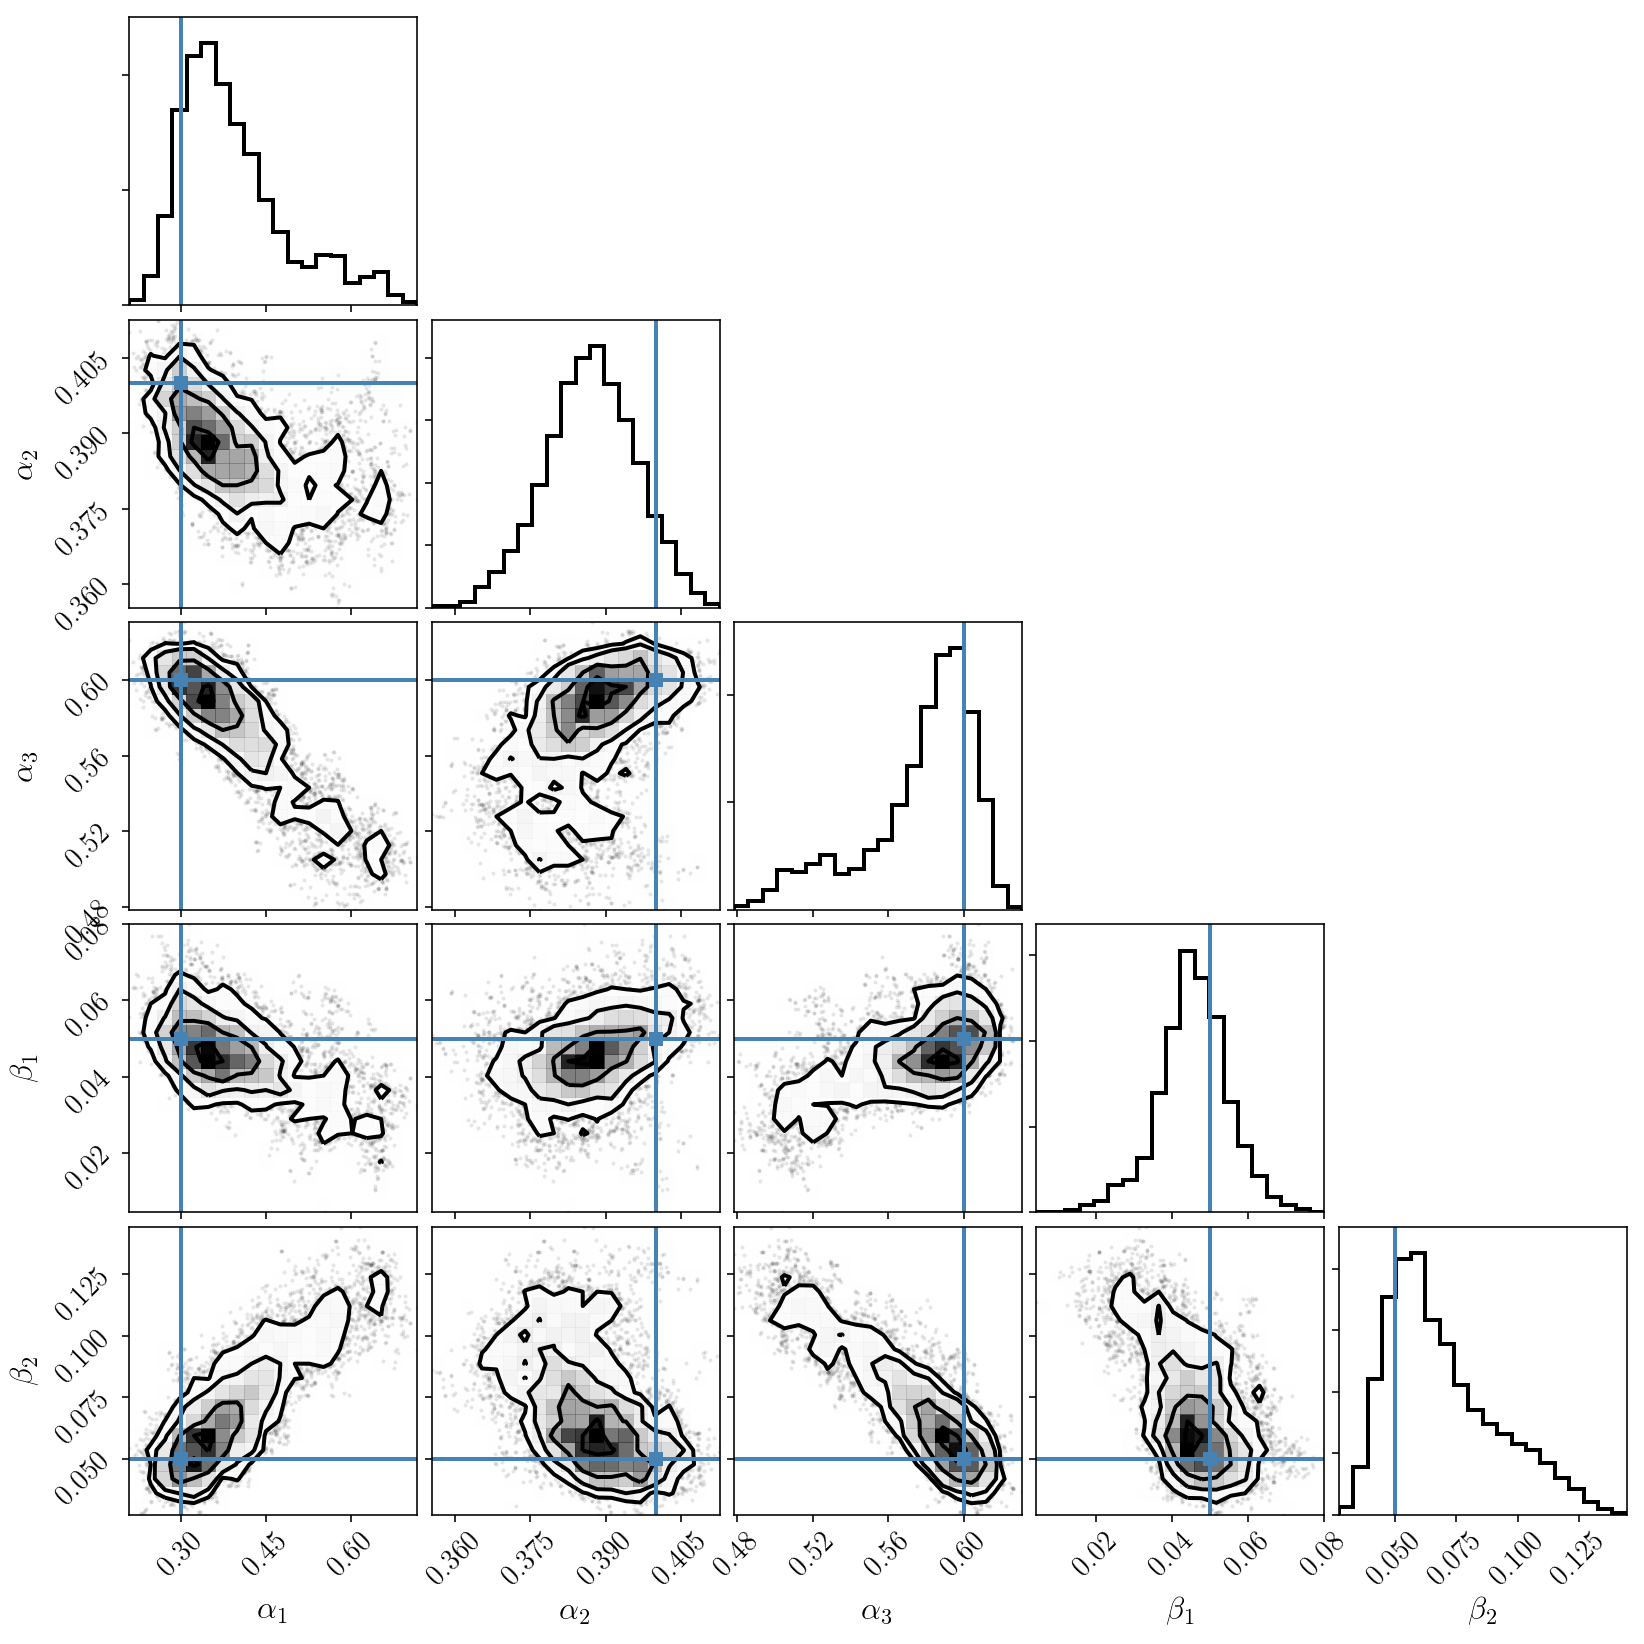

In [80]:
_ = corner.corner(param_samples_hyperonly, truths=params, labels=param_names)

The marginalized posterior distribution for pairs of parameters looks good. Let's look at the marginalized posterior for the individual parameters and compare with the results we obtained with emcee.

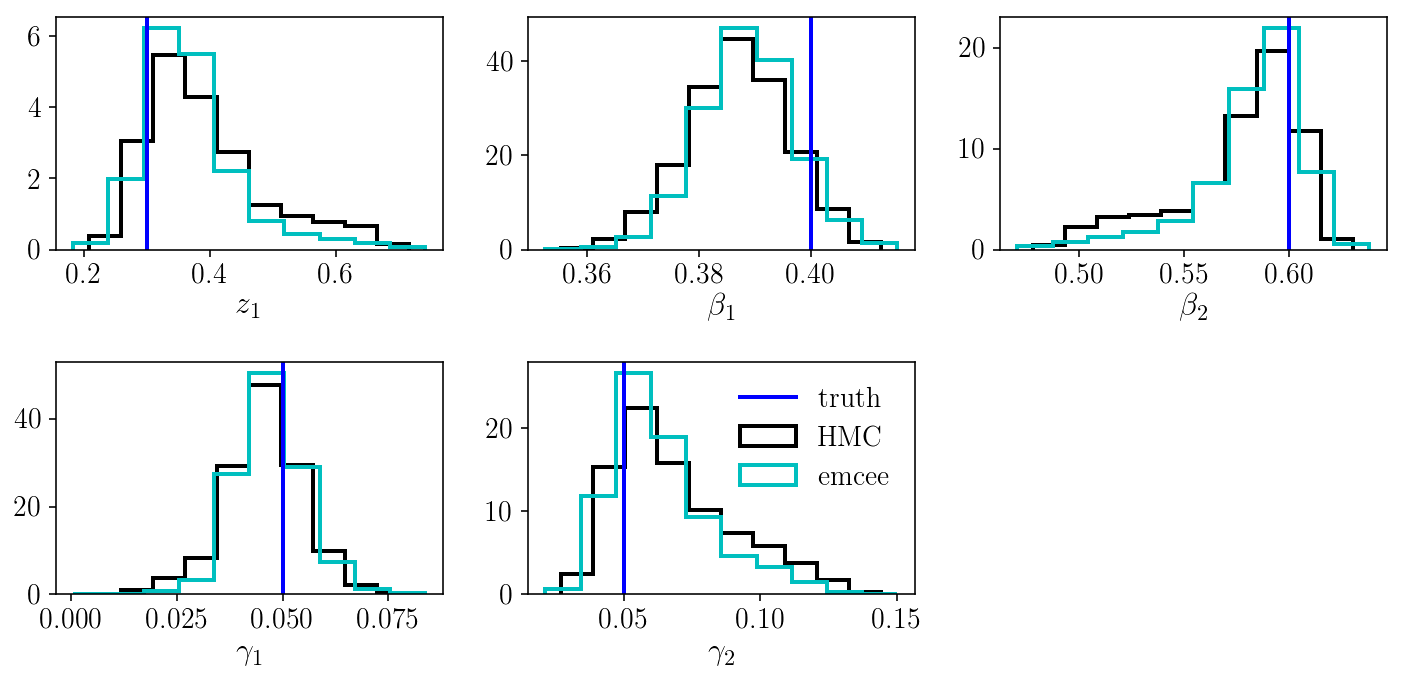

In [87]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].hist(param_samples_hyperonly[:, i], histtype='step', normed=True, label='HMC')
    rr = axs[i].get_xlim()
    axs[i].hist(sampler.flatchain[:, i], range=rr, histtype='step', normed=True, label='emcee')
    axs[i].axvline(params[i], c='b', label='truth')
    axs[i].set_xlabel(param_names[i])
axs[-2].legend(frameon=False)
plt.delaxes(axs[-1])
fig.tight_layout()

As we can see, the HMC run was successful, which is good! However, it is slower than emcee. This is because, despite using gradient information to obtain a higher acceptance rate (close to 1, as opposed to 0.3), our HMC sampler is not parallelized. And emcee is generally blazingly fast. 

However, we will now sample the full posterior distribution, which emcee cannot deal with since it has way too many parameters.

## Sampling the full posterior distribution with latent variables

We will now sample 

$p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\})\propto p(\vec{f},\vec{\beta}, \vec{\gamma}) \prod_{i=1}^N  \sum_{b=1}^B f_b \mathcal{N}(x_i|\beta_b,\gamma^2_b)\mathcal{N}(y_i|x_i,\sigma^2_i)$

use the same technical tricks as before.

In [82]:
def sublnprob_withxis(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(xis[:, None], betas[None, :], gammas[None, :]) + \
        lngaussian(yis[:, None], xis[:, None], sigmais[:, None])
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_withxis(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_withxis(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_withxis_grad = grad(sublnprob_withxis)
sublnprob_withxis_hessian = hessian(sublnprob_withxis)

def lnprob_withxis_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_withxis_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_withxis_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_withxis_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess

params = np.concatenate([zs, betas, gammas, xis])
#print(lnprob_withxis(params), lnprob_withxis_grad(params), lnprob_withxis_hessian(params))

def fun(params):
    return lnprob_withxis(params)
def fun_grad(params):
    return lnprob_withxis_grad(params)

# Numerically test the gradient
relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_withxis_hessian(params)

# Numerically test the hessian
relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

In [83]:
num_samples, burnin = 10000, 2000

params = np.concatenate([zs, betas, gammas, xis])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.03
bounds[:, 1] = 0.97
param_samples_withxis = np.zeros((num_samples, params.size))
param_samples_withxis[0, :] = params 

hess = np.abs(lnprob_withxis_hessian(params))
for i in range(1, num_samples):
    step_size = 10.**np.random.uniform(-3, -1)
    num_steps = np.random.randint(5, 20)
    if i % 500 == 0:
        print(i, end=" ")
        newparams = np.mean(param_samples_withxis[0:i-1, :], axis=0)
        hess = np.abs(lnprob_withxis_hessian(newparams))
    param_samples_withxis[i, :] =\
        hmc_sampler(param_samples_withxis[i-1, :],
                    lnprob_withxis, lnprob_withxis_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_withxis = param_samples_withxis[burnin:, :]

500 Sample rejected due to small acceptance probability ( 6.66483689618e-05 )
HMC steps and stepsize: 18 0.07892265361761533
Sample rejected due to small acceptance probability ( 1.66378696662e-36 )
HMC steps and stepsize: 10 0.07345533818991629
Sample rejected due to small acceptance probability ( 0.00827089789029 )
HMC steps and stepsize: 19 0.0754095802138479
Sample rejected due to small acceptance probability ( 4.63399714667e-05 )
HMC steps and stepsize: 15 0.09220484664669092
Sample rejected due to small acceptance probability ( 1.81082881957e-36 )
HMC steps and stepsize: 11 0.09355144589270446
Sample rejected due to small acceptance probability ( 0.00238743646475 )
HMC steps and stepsize: 6 0.05821348930788327
Sample rejected due to small acceptance probability ( 7.58309662408e-07 )
HMC steps and stepsize: 15 0.061699136630546346
1000 1500 2000 2500 3000 3500 4000 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Sample rejected due to

Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Sample rejected due to small acceptance probability ( 2.75950728816e-36 )
HMC steps and stepsize: 13 0.04118936063468725
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Sample rejected due to small acceptance probability ( 3.44043330533e-103 )
HMC steps and stepsize: 11 0.03330928403440802
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 305
Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 3

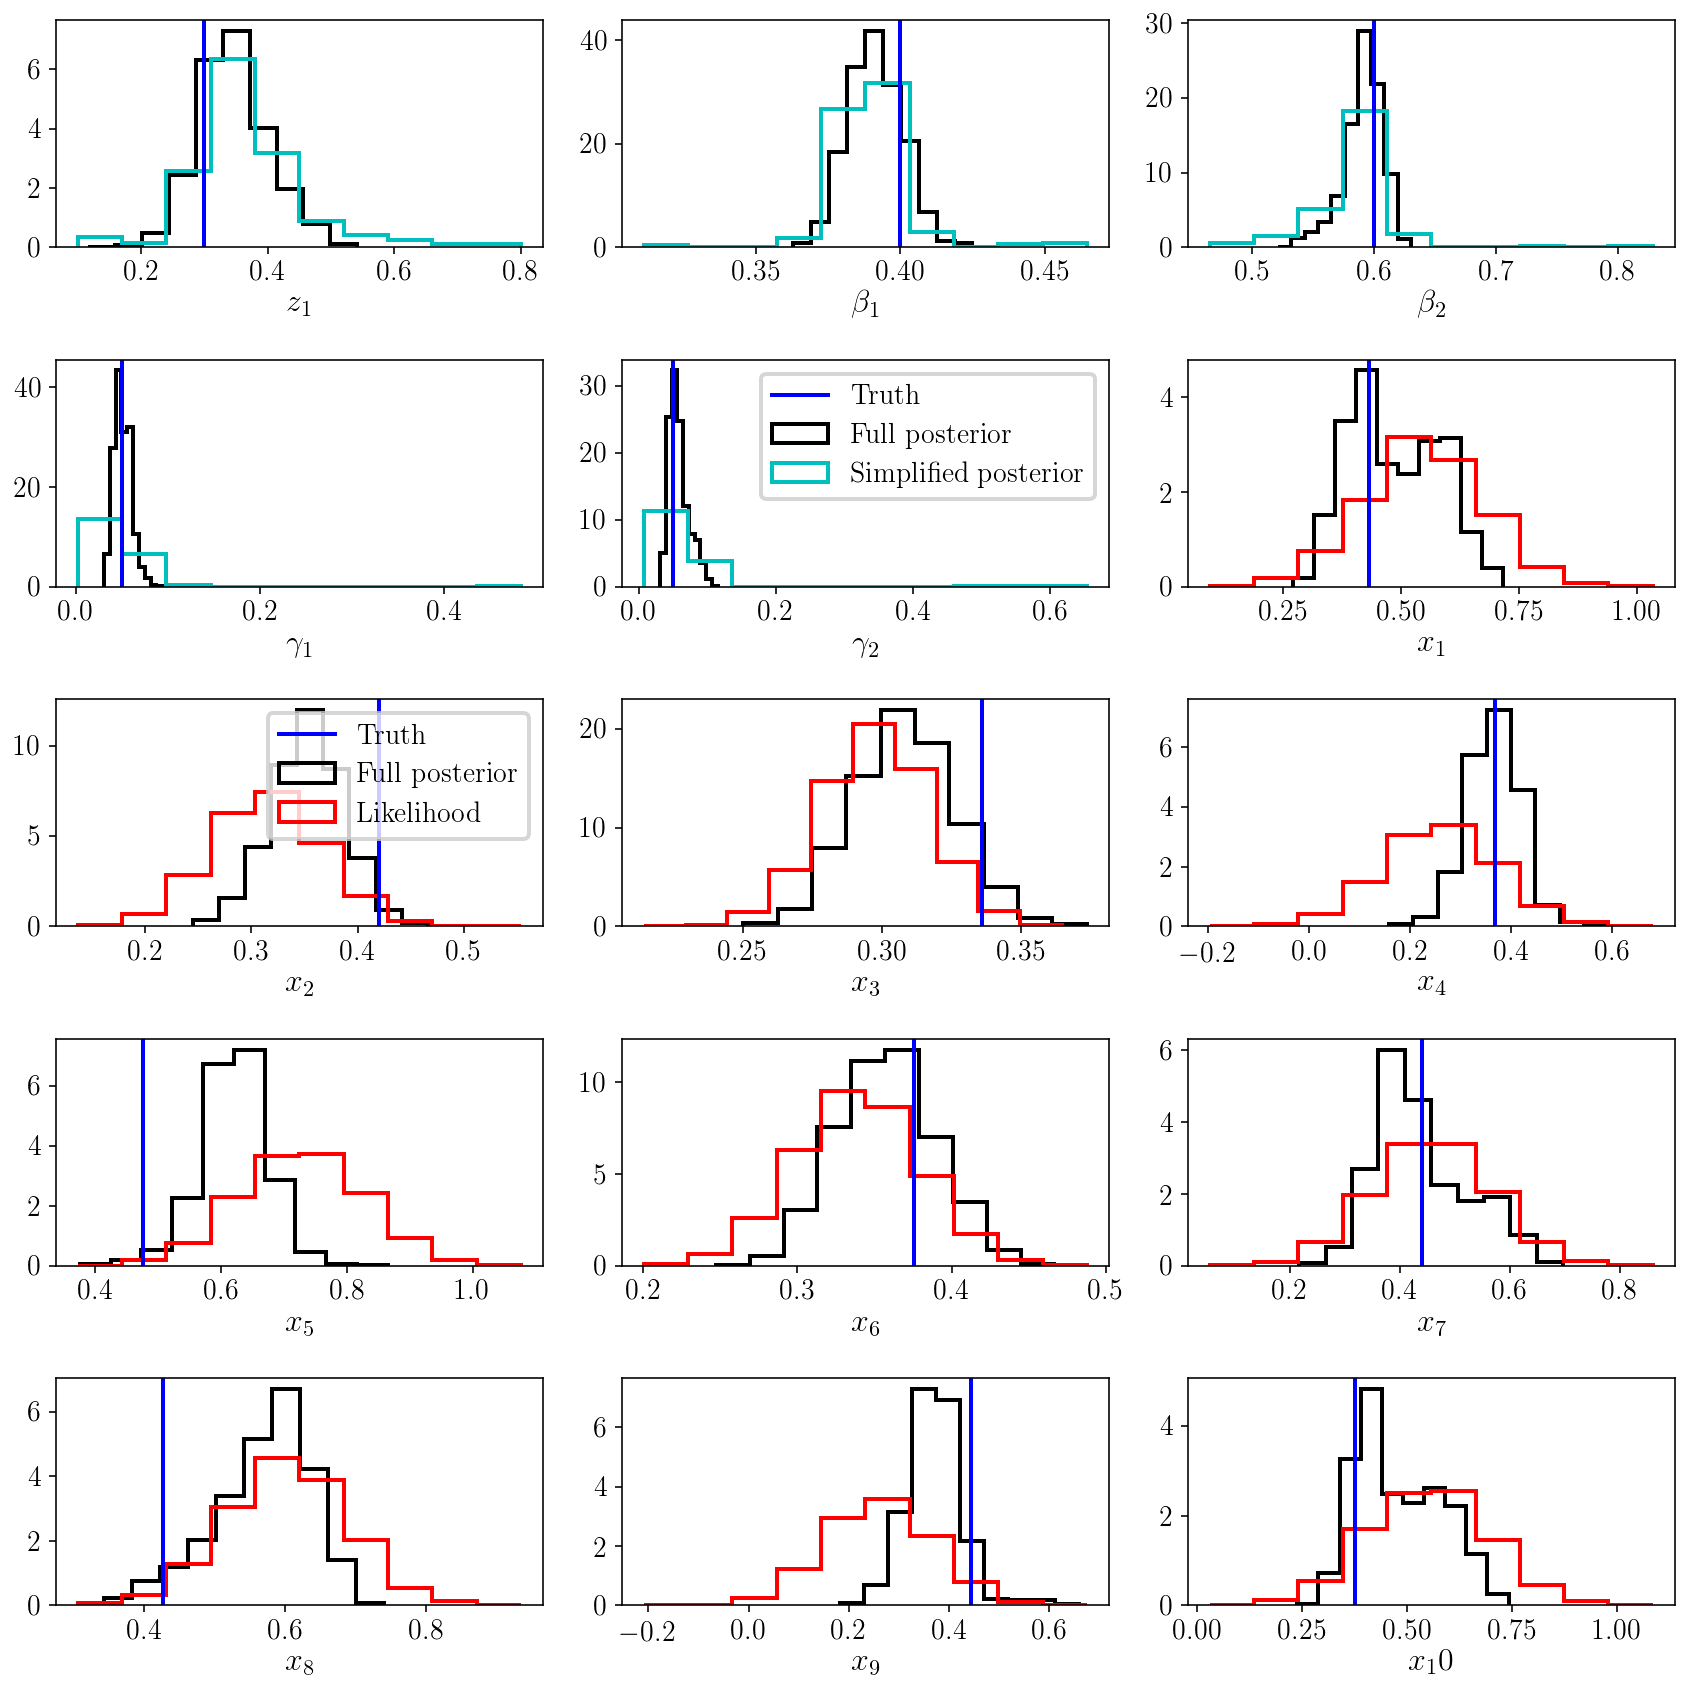

In [84]:
param_names = [r'$z_'+str(i+1)+'$' for i in range(nt-1)] +\
    [r'$\beta_'+str(i+1)+'$' for i in range(nt)] +\
    [r'$\gamma_'+str(i+1)+'$' for i in range(nt)]+\
    [r'$x_'+str(i+1)+'$' for i in range(nobj)]
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.ravel()
for i in range(axs.size):
    axs[i].set_xlabel(param_names[i])
    axs[i].hist(param_samples_withxis[:, i], histtype='step', normed=True, label='Full posterior')
    if i < 5:
        axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True, label='Simplified posterior')    
    axs[i].axvline(params[i], c='b', label='Truth')
    if i >= 5:
        likedraws = yis[i-5] + np.random.randn(param_samples_withxis[:, i].size) * sigmais[i-5]
        axs[i].hist(likedraws, histtype='step', normed=True, color='red', label='Likelihood')
    if i == 6 or i == 4:
        axs[i].legend(loc='upper right', frameon=True)
fig.tight_layout()

The marginalized posterior distribution looks good. For the population parameters $\vec{z}, \vec{\beta}, \vec{\gamma}$, it matches what we obtained with the simplified posterior distribution. This is remarkable because we have added a ton of parameters to the model, and explored a much bigger parameter volume. Thanks to HMC, this exploration was efficient, and we were able to numerically marginalize over all the latent variables $x_i$'s and recover the results from the analytic solution, the simplified posterior distribution.

The other panels in the figure above show a comparison of the posterior distribution on each $x_i$ versus the likelihood function $p(y_i | x_i)$. This is a typical illustration of Bayesian shrinkage: by fitting a model to the population of objects, we in turn improve the individual estimates. It doesn't matter that those parameters are latent - they are connected via a hierarchical probabilistic model, so the information gained in one part of the model might actually affect the rest of the model. This is a theme that we have explored and will continue to explore in other tutorials.

## Final comments: number of components and multimodality

We have not discussed a number of additional issues that may arise, including what happens if the data are very noisy and/or the components significantly overlap. Those are common with mixture models.

Indeed, those can create new degeneracies in the posterior distribution, since components can more easily be interchanged if they overlap or in the presence of significant noise. One can still find a prior that alleviates those degeneracies, but this might not be sufficient. In that case, an HMC sampler that is carefully tuned should still work. But if the distribution is really multimodal, then one could adopt a "tempered" HMC sampler. For example, the approach of https://arxiv.org/abs/1704.03338 is interesting.

(By tuning, I refer to the parameters of the HMC algorithm: the step size, number of steps, and mass matrix. There is a lot of litterature on how to tune this to make the exploration of complicated posterior distribution more efficient. In particular, one wants an acceptance rate close to one, and the maximum step size and minimum number of steps that yield to a good MCMC chain. A good metric for that is the correlation between samples - we want samples that are as independent as possible, and fully explore the posterior distribution.)

Another related question is how to find a suitable prior to alleviate labelling degeneracies in $>1$ dimensions. This is possible, but may require some careful thinking. Again, the key is to order the components in a quasi-unique fashion. 

But the most critical question we have not  mentioned so far is the choice of number of components. In most real-world problems, one does not know how many components to use. This is a vast, deep question which is addressed in countless papers, many of them beyond the scope of this tutorial. The classical approach boils down to doing multiple runs with different number of components, and performing model selection (in a Bayesian fashion) or cross-validation (in a frequentist fashion) to select the best number of components. Indeed, the denominator of our full posterior distribution (neglected previously) is the evidence

$E = p( \{y_i, \sigma_i\} = \int p(\vec{f},\vec{\beta}, \vec{\gamma}, \{ x_i \} | \{y_i, \sigma_i\}) \mathrm{d} \vec{f} \mathrm{d}\vec{\beta} \mathrm{d} \vec{\gamma} \mathrm{d} \{ x_i \}$

In other words, one way or another, a huge multidimensional integral is needed. Calculating evidences accurately is a research topic on its own. One can run a very long MCMC chain and perform this integral numerically. Or adopt a more adequate sampler that explicitly targets the evidence (e.g., via nested sampling). Those options are good. For two runs with two different numbers of components $B_1$ and $B_2$, the evidence ratio (also called Bayes factor) will allow one to perform model selection and pick the preferred number of components. Even better, one could simply consider both models simultaneously, and weight the samples in each model by their respective evidences. All of those could be performed with nested sampling.

Note that with mixture models, we are in a very particular situation: by fixing one or multiple $z_i$ or $\alpha_i$ to zero or one, the number of components has effectively changed. We say that the models are **nested**. Nested models are very convenient and are worth learning about. Many physical models are nested, and this hugely simplifies model comparison, via the Savage Dickey density ratio, for example.

Equivalently, one could adopt a trans-dimensional approach and explore the space of models with a variable number of components. It is in fact equivalent to multiple-run solution we just discussed. Either way, there are various pieces of technology to achieve that, such as trans-dimensional MCMC (which explicitely adds and removes parameters), which we will not discuss here. But you should immediatly spot that we have already done that: when we ran nested sampling with three components, we found that the posterior distribution was naturaly peaked at two components, with the third one often set to zero. The point is: for nested models, it is not that hard to perform a trans-dimensional sampling. One only needs to write the posterior distribution in a convenient, nested form, and think carefully about what priors would help pinning down (i.e., sampling) the most probably number of components. 

This brings us to our final point of discussion and experiment.

## Interpretability of mixture models.

Let's run PolyChord with more components - say four - and show the result in data space, i.e., plot the true density of objects and that infered with our Gaussian mixture model.  

In [89]:
code4 = """
PolyChord.run_nested_sampling(mixturemodellnprob, ndim, nderived, prior=prior,
                              file_root='mixturemodellnprob', do_clustering=False,
                              nlive=50*ndim, update_files=50*ndim, 
                              num_repeats=5*ndim, boost_posterior=1)
"""


nt2 = 4
text_file = open("run_PyPolyChord.py", "w")
text_file.write(code1 % nt2 + code4)
text_file.close()

# go in the terminal and run
# rm -rf chains ; mkdir chains ; mkdir chains/clusters ; python run_PyPolyChord.py
# If you get a segmentation fault, you'll need to compile PolyChord with extra flags
# to make sure the stack size is sufficient.

[  1.93668900e-01   4.02160760e-06   3.49779470e-05   3.63353080e-01
   1.15148210e-01   7.66401030e-04   1.49375070e-04   3.00055420e-02
   3.00113710e-02   3.00167730e-02   3.00079220e-02]


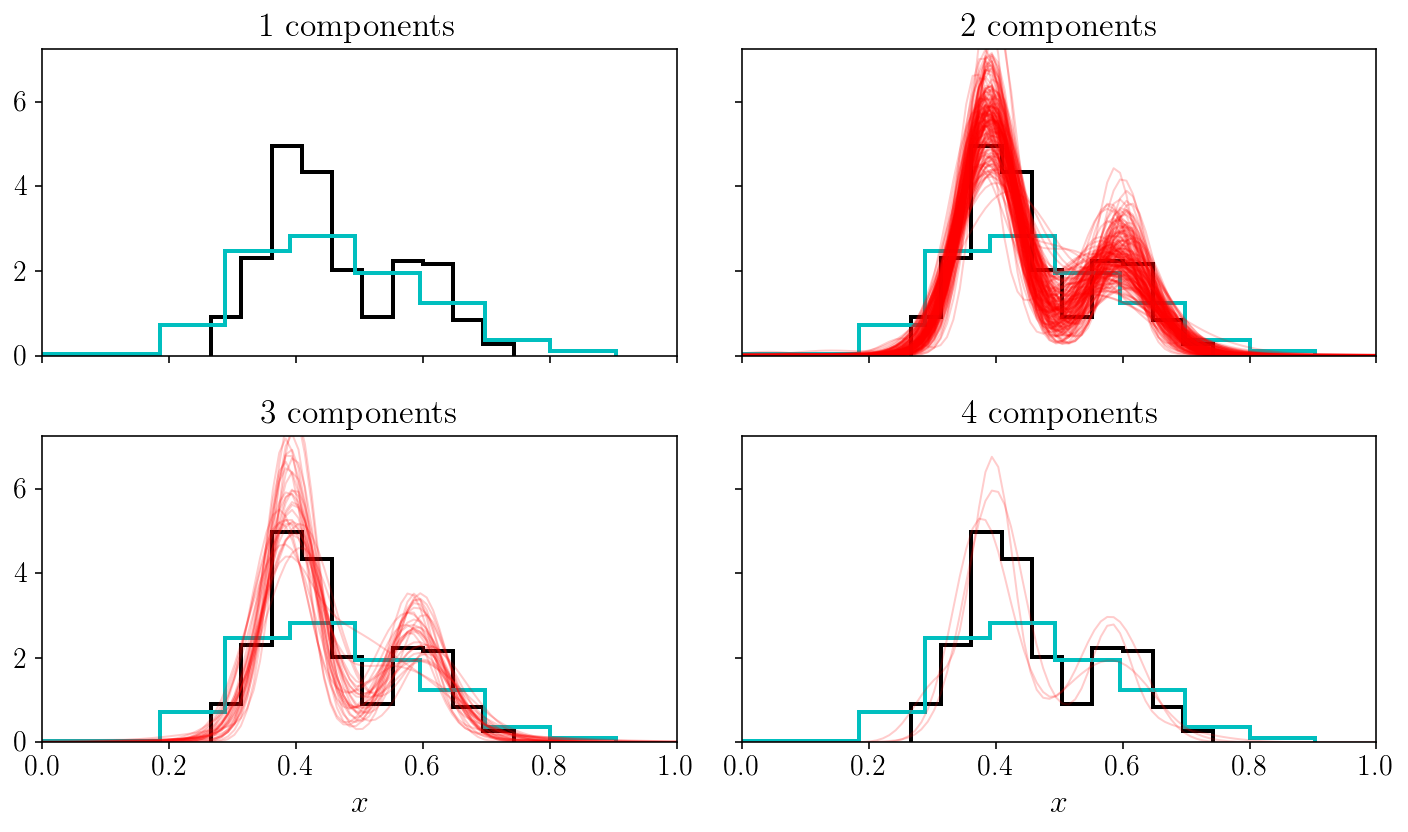

In [93]:
samples = np.genfromtxt('chains/mixturemodellnprob_equal_weights.txt')[:, 2:]
print(np.min(samples, axis=0))
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
axs = axs.ravel()
for i in np.random.choice(samples.shape[0], 200, replace=False):
    alphas2 = zs_to_alphas(samples[i, 0:nt2-1])
    alphas2 /= alphas2.max()
    j = np.sum(alphas2 > 0.1) - 1
    alphas2 /= alphas2.sum()
    betas2 = samples[i, nt2-1:2*nt2-1]
    gammas2 = samples[i, 2*nt2-1:3*nt2-1]
    p_x_grid2 = alphas2[None, :] * np.exp(-0.5*((x_grid[:, None] - betas2[None, :])/gammas2[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas2[None, :]
    p_x_grid2 = np.sum(p_x_grid2, axis=1)
    #p_x_grid2 /= p_x_grid2.max() / p_x_grid.max()
    axs[j].plot(x_grid, p_x_grid2, color='r', alpha=0.2, lw=1)
for j in range(4):
    #axs[j].plot(x_grid, p_x_grid[:, :].sum(axis=1), c='k')
    axs[j].set_title(str(j+1)+' components')
    axs[j].hist(xis, histtype='step', normed=True)
    axs[j].hist(yis, histtype='step', normed=True)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, np.max(p_x_grid)*1.3])
axs[-1].set_xlabel(r'$x$')
axs[-2].set_xlabel(r'$x$')
fig.tight_layout()

In this figure, we have separated the models into their number of components (specifically: any component having an amplitude ten times smaller than the largest component is not counted). Since we randomly picked posterior stamples, the number of curves arriving in each subpanel is also telling us something about the most probably number of components. In fact, we could relate those relative densities to Bayes factors for the nest models with 1, 2, 3 and 4 components. What we are doing is much more generic and straightforward: we have implicitly performed a trans-dimensional sampling since we have allowed some of the compoments to be zero. 

One final comment: you can see that except for the one-component case, most of our model samples indeed capture the true bimodal nature of the density. However, why are some of those models made of three and four components? This happens because we have not restriced the components to overlap. This creates yet another degeneracy on top of the labeling one: the fact that any component can be decomposed into sub-components with lower amplitudes. When considering a larger space of models (i.e., trans-dimensional), this is a complicated problem. This is related to the **interpretability** of mixture models. Luckily for us, it can be solved in two ways: in a fully Bayesian inference setting like we described in this tutorial, one can easily adopt  a prior that mitigates this effect, for instance by forcing the components to be separated by some amount. An alternative which is particularly popular in the realm of empirical Bayesian inference and maximum a-posteriori solutions (i.e., finding the optimum of the posterior distribution only) is a set of "split and merge" methods, allowing to litteraty split and merge some of the components when relevant.